# **APRCA Test Set Evaluations**

This notebook is only used to test the APRCA Machine learning Model on unseen test sets. Refer to APRCA notebook for entire machine learning program

## **Package Import**

In [1]:
#RAUF TAGHI 430004636
#importing pandas package to make dataframes
import pandas as pd

#importing plotting package from matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

#importing numpy package for computation
import numpy as np

#import scipy for stat preprocessing
from scipy import stats

#import sklearn datasplit selection and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#confusion matrix imports
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

#Tensorflow Imports
import tensorflow as tf

#to hold data files
import pathlib
import shutil
import tempfile


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Loading Machine Learning Model**

In [3]:
#Load the model
CNNModel_Test = tf.keras.models.load_model('/content/drive/MyDrive/Models/APRCA_modelFINAL.h5')
CNNModel_Test_Arm = tf.keras.models.load_model('/content/drive/MyDrive/Models/APRCA_model_armFINAL.h5')

#model2 - Locomotive with Frame Size 10
#model3 - Locomotive with Frame Size 30
#model30f - Locomotive with Frame Size 60 (Alternative)

#HIGHVALD40 - Arm Motion with Frame Size 40
#HIGHVALD60 - Arm Motion with Frame Size 60

In [4]:
#Frame Preparation
#Sampling Frequency Fs, Pre-defined as 30Hz
Fs = 30

#Frame Size, determines sample amount
Frame_Size = Fs * 60  #90 samples - 3 Seconds

#Hop Size, Determines if next sample set overlaps with previous sample set
Hop_Size = Fs

#Create the Get Frames Function, this will split the dataframe and retrieve the Data into Frames and Labels
def Get_Frames(DataFrame, Frame_Size, Hop_Size):

  #Number of Features in Dataframe
  N_FEATURES = 9

  #Define Frame and Label Arrays
  Frames = []
  Labels = []

  #Iterate through dataframe to capture values
  for i in range(0, len(DataFrame) - Frame_Size, Hop_Size):
    ax = DataFrame['Accelerometer X (mGal)'].values[i: i + Frame_Size]
    ay = DataFrame['Accelerometer Y (mGal)'].values[i: i + Frame_Size]
    az = DataFrame['Accelerometer Z (mGal)'].values[i: i + Frame_Size]

    gx = DataFrame['Gyro X'].values[i: i + Frame_Size]
    gy = DataFrame['Gyro Y'].values[i: i + Frame_Size]
    gz = DataFrame['Gyro Z'].values[i: i + Frame_Size]

    mx = DataFrame['Magnetic X'].values[i: i + Frame_Size]
    my = DataFrame['Magnetic Y'].values[i: i + Frame_Size]
    mz = DataFrame['Magnetic Z'].values[i: i + Frame_Size]

    #Retrieve most used label in current loop
    Label = stats.mode(DataFrame['Label'][i: i + Frame_Size])[0]

    #Append Arrays
    Labels.append(Label)
    Frames.append([ax, ay, az, gx, gy, gz, mx, my, mz])

  #Reshape
  Frames = np.asarray(Frames).reshape(-1, Frame_Size, N_FEATURES)
  Labels = np.asarray(Labels)

  return Frames, Labels


## **Test Database Github Imports**

In [5]:
#TRAINING DATASET 1 S1-ADL3
url = 'https://raw.githubusercontent.com/RaufTaghi/APRCA-Sample-Database/RaufTaghi-SampleDatasetsFinal/OPPORTUNITY%20UnmarkedDatasetOne.csv'
Accelerometer_Gyro_Set_One = pd.read_csv(url)

#Remove any row that has corrrupt Time Values
Accelerometer_Gyro_Set_One = Accelerometer_Gyro_Set_One.dropna(subset=['Time (ms)'])


#TRAINING DATASET 2 S1-ADL4
url = 'https://raw.githubusercontent.com/RaufTaghi/APRCA-Sample-Database/RaufTaghi-SampleDatasetsFinal/OPPORTUNITY%20UnmarkedDatasetTwo.csv'
Accelerometer_Gyro_Set_Two = pd.read_csv(url)

#Remove any row that has corrrupt Time Values
Accelerometer_Gyro_Set_Two = Accelerometer_Gyro_Set_Two.dropna(subset=['Time (ms)'])
Accelerometer_Gyro_Set_Two['Time (ms)'] = Accelerometer_Gyro_Set_Two['Time (ms)'] + 1109056 + 33 #increment time to add to new dataset

Accelerometer_Gyro_data = pd.concat([Accelerometer_Gyro_Set_One, Accelerometer_Gyro_Set_Two], ignore_index = True)
Accelerometer_Gyro_data.tail()


Time (ms)  Accelerometer X (mGal)  Accelerometer Y (mGal)  \
66223    2207411                     NaN                     NaN   
66224    2207445                     NaN                     NaN   
66225    2207478                     NaN                     NaN   
66226    2207511                     NaN                     NaN   
66227    2207545                     NaN                     NaN   

       Accelerometer Z (mGal)  Gyro X  Gyro Y  Gyro Z  Magnetic X  Magnetic Y  \
66223                     NaN     NaN     NaN     NaN         NaN         NaN   
66224                     NaN     NaN     NaN     NaN         NaN         NaN   
66225                     NaN     NaN     NaN     NaN         NaN         NaN   
66226                     NaN     NaN     NaN     NaN         NaN         NaN   
66227                     NaN     NaN     NaN     NaN         NaN         NaN   

       Magnetic Z  Locomotion  Arm Motion  Arm Object  
66223         NaN           0           0           0  
66224         NaN           0           0           0  
66225         NaN           0           0           0  
66226         NaN           0           0           0  
66227         NaN           0           0           0

In [6]:
#TRAINING DATASET 2 S1-ADL4
url = 'https://raw.githubusercontent.com/RaufTaghi/APRCA-Sample-Database/RaufTaghi-SampleDatasetsFinal/OPPORTUNITY%20UnmarkedDatasetTwo.csv'
Accelerometer_Gyro_Set_data = pd.read_csv(url)
#Remove any row that has corrrupt Time Values
Accelerometer_Gyro_Set_data = Accelerometer_Gyro_Set_Two.dropna(subset=['Time (ms)'])

## **Locomotion Test Set Data Assessment**

In [7]:
#Remove all of the NaN data plots that appear do not have an associated motion (Locomotion = 0)
Accelerometer_Gyro_data.drop(Accelerometer_Gyro_data.loc[Accelerometer_Gyro_data['Locomotion']==0].index, inplace=True)
#Remove NaN Accelerometer and Gyro rows (rows without measurable motion data)
Accelerometer_Gyro_data.drop(Accelerometer_Gyro_data.loc[Accelerometer_Gyro_data['Accelerometer X (mGal)']=='NaN'].index, inplace=True)

#info of the dataset for reference
#balance data
Accelerometer_Gyro_data['Accelerometer X (mGal)'] = Accelerometer_Gyro_data['Accelerometer X (mGal)'].astype('float')
Accelerometer_Gyro_data['Accelerometer Y (mGal)'] = Accelerometer_Gyro_data['Accelerometer Y (mGal)'].astype('float')
Accelerometer_Gyro_data['Accelerometer Z (mGal)'] = Accelerometer_Gyro_data['Accelerometer Z (mGal)'].astype('float')

Accelerometer_Gyro_data['Gyro X'] = Accelerometer_Gyro_data['Gyro X'].astype('float')
Accelerometer_Gyro_data['Gyro Y'] = Accelerometer_Gyro_data['Gyro Y'].astype('float')
Accelerometer_Gyro_data['Gyro Z'] = Accelerometer_Gyro_data['Gyro Z'].astype('float')

Accelerometer_Gyro_data['Magnetic X'] = Accelerometer_Gyro_data['Magnetic X'].astype('float')
Accelerometer_Gyro_data['Magnetic Y'] = Accelerometer_Gyro_data['Magnetic Y'].astype('float')
Accelerometer_Gyro_data['Magnetic Z'] = Accelerometer_Gyro_data['Magnetic Z'].astype('float')

#define activities list and then evaluate the amount of value counts we are working with for each motion type
activities = Accelerometer_Gyro_data['Locomotion'].value_counts().index

#balance dataframe so that each activity has the same number of instances
Min_Value = Accelerometer_Gyro_data['Locomotion'].value_counts()
Min_Value = Min_Value[5]
# In Locomotion Data:
## 1 = Stand
Stand = Accelerometer_Gyro_data[Accelerometer_Gyro_data['Locomotion'] == 1].copy()
## 2 = Walk
Walk = Accelerometer_Gyro_data[Accelerometer_Gyro_data['Locomotion'] == 2].copy()
## 4 = Sit
Sit = Accelerometer_Gyro_data[Accelerometer_Gyro_data['Locomotion'] == 4].copy()
## 5 = Lie
Lie = Accelerometer_Gyro_data[Accelerometer_Gyro_data['Locomotion'] == 5].copy()

Accelerometer_Gyro_Balanced = pd.DataFrame()
Accelerometer_Gyro_Balanced = Accelerometer_Gyro_Balanced.append([Stand, Walk, Sit, Lie])

Accelerometer_Gyro_Balanced['Locomotion'].value_counts()

from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
Accelerometer_Gyro_Balanced['Label'] = label.fit_transform(Accelerometer_Gyro_Balanced['Locomotion'])
#Accelerometer_Gyro_Balanced.head()
label.classes_

#Normalize Features
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(Accelerometer_Gyro_data)

#Define X and Y parameters
X_Locomotive = Accelerometer_Gyro_Balanced[['Accelerometer X (mGal)', 'Accelerometer Y (mGal)', 'Accelerometer Z (mGal)',
                                            'Gyro X', 'Gyro Y', 'Gyro Z',
                                            'Magnetic X', 'Magnetic Y', 'Magnetic Z']]
Y_Locomotive = Accelerometer_Gyro_Balanced['Label']

#Standardize Data
scaler = StandardScaler()
X_Locomotive = scaler.fit_transform(X_Locomotive)

X_Locomotive_Scale = pd.DataFrame(data = X_Locomotive, columns = ['Accelerometer X (mGal)', 'Accelerometer Y (mGal)', 'Accelerometer Z (mGal)',
                                                                  'Gyro X', 'Gyro Y', 'Gyro Z',
                                                                  'Magnetic X', 'Magnetic Y', 'Magnetic Z'])
X_Locomotive_Scale['Label'] = Y_Locomotive.values
X_Locomotive_Scale

#Create X and y by calling the Get_Frames Function
#label_exist = 'yes'
X, y = Get_Frames(X_Locomotive_Scale, Frame_Size, Hop_Size)

<ipython-input-7-5f95b20397b1>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accelerometer_Gyro_Balanced = Accelerometer_Gyro_Balanced.append([Stand, Walk, Sit, Lie])


### Confusion Matrix

51/51 [==============================] - 11s 210ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

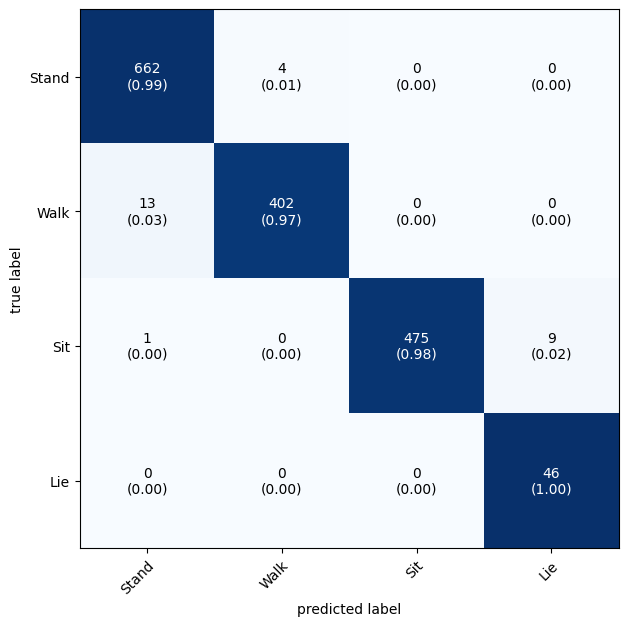

In [8]:
predictions = CNNModel_Test.predict(X, verbose = 1)
#np.argmax(predictions, axis=1)

classes=np.argmax(predictions,axis=1)

mat = confusion_matrix(y, classes)

# Remove rows where all elements are 0
mat = mat[~np.all(mat == 0, axis=1)]
# Remove columns where all elements are 0
mat = mat[:, ~np.all(mat == 0, axis=0)]

Locomotion_Labels = np.array(['Stand', 'Walk', 'Sit', 'Lie'])
plot_confusion_matrix(conf_mat = mat, show_normed = True, class_names = Locomotion_Labels, figsize =(7,7))

### Label Plots

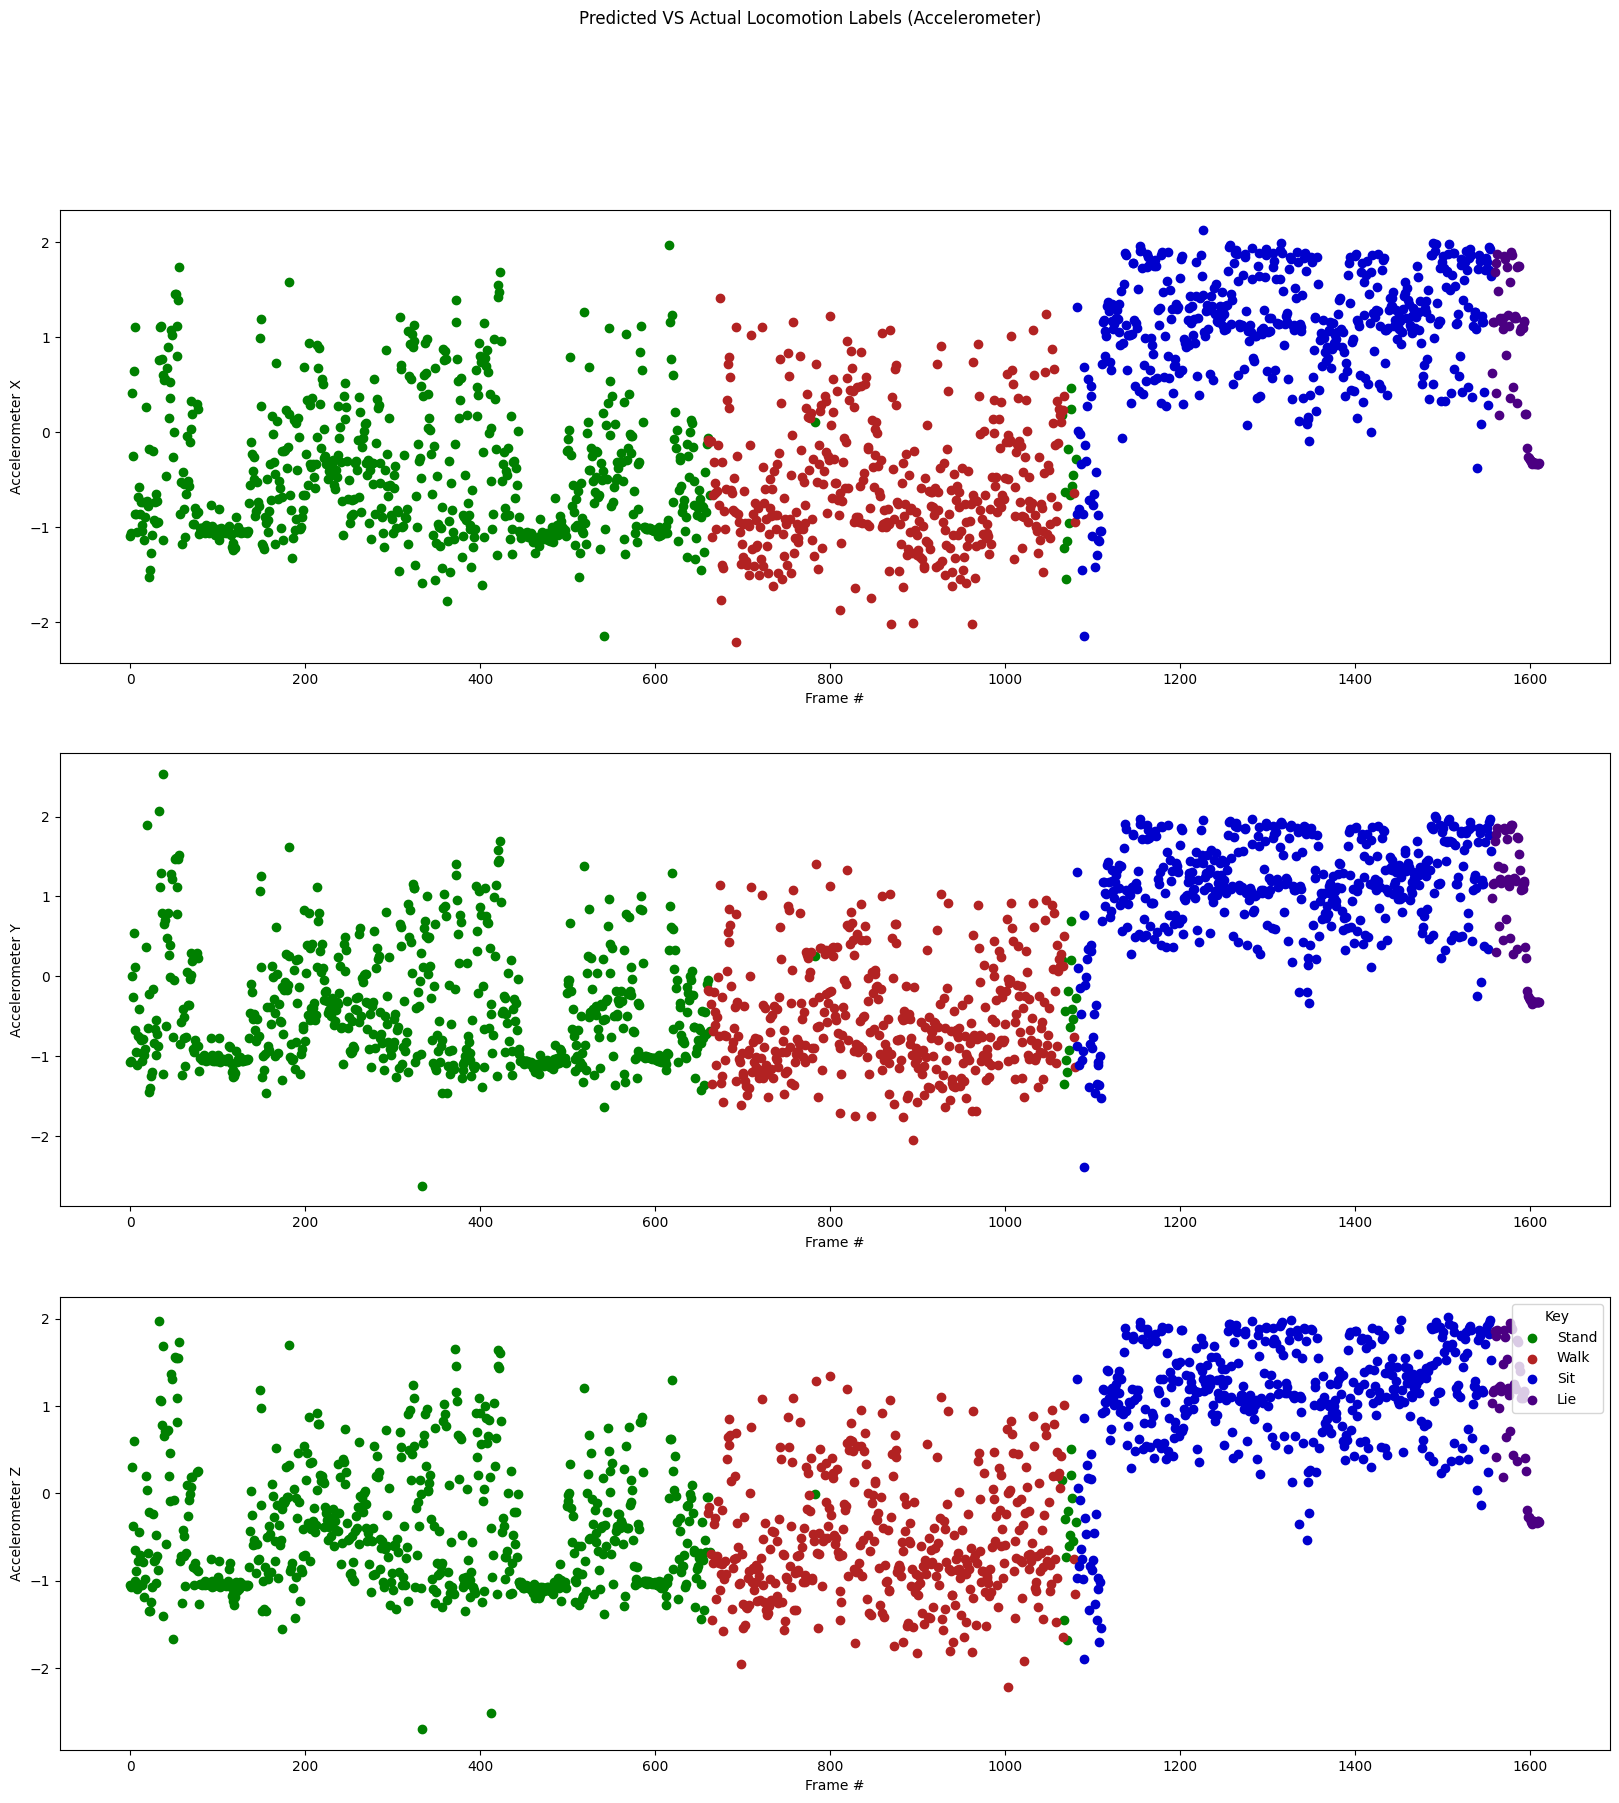

In [9]:
locomotion_colors = { 0: 'green', 1: 'firebrick', 2: 'mediumblue', 3: 'indigo', 4: 'seagreen', 5: 'goldenrod'}

#Create new dataframe
X_values = X[:, 0]
length = np.arange(len(X_values))
Prediction_values = predictions[:, 0]
A_G_M = pd.DataFrame(X_values)

#define columns
A_G_M.columns= ['Accelerometer X', 'Accelerometer Y', 'Accelerometer Z', 'Gyro X', 'Gyro Y', 'Gyro Z', 'Magnetic X', 'Magnetic Y', 'Magnetic Z']
#add labels
A_G_M["Actual Label"] = y
A_G_M["Predicted Label"] = classes
#create new true false column that determines if the actual label was equal to the predicted label
A_G_M['Label Accuracy'] = np.where(A_G_M['Actual Label'] == A_G_M['Predicted Label'], 1, 0)
A_G_M['Increment'] = length

#create color coding keys
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Locomotion Labels (Accelerometer)')

#Accelerometer Plot
for key, group in A_G_M.groupby('Predicted Label'):
    axs[0].scatter(group['Increment'], group['Accelerometer X'], label=key, c=locomotion_colors[key])
for key, group in A_G_M.groupby('Predicted Label'):
    axs[1].scatter(group['Increment'], group['Accelerometer Y'], label=key, c=locomotion_colors[key])
for key, group in A_G_M.groupby('Predicted Label'):
    axs[2].scatter(group['Increment'], group['Accelerometer Z'], label=key, c=locomotion_colors[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Accelerometer X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Accelerometer Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Accelerometer Z')
plt.legend(title='Key', loc = "upper right", labels= ["Stand", "Walk", "Sit", "Lie"])

# Show the plot
plt.show()

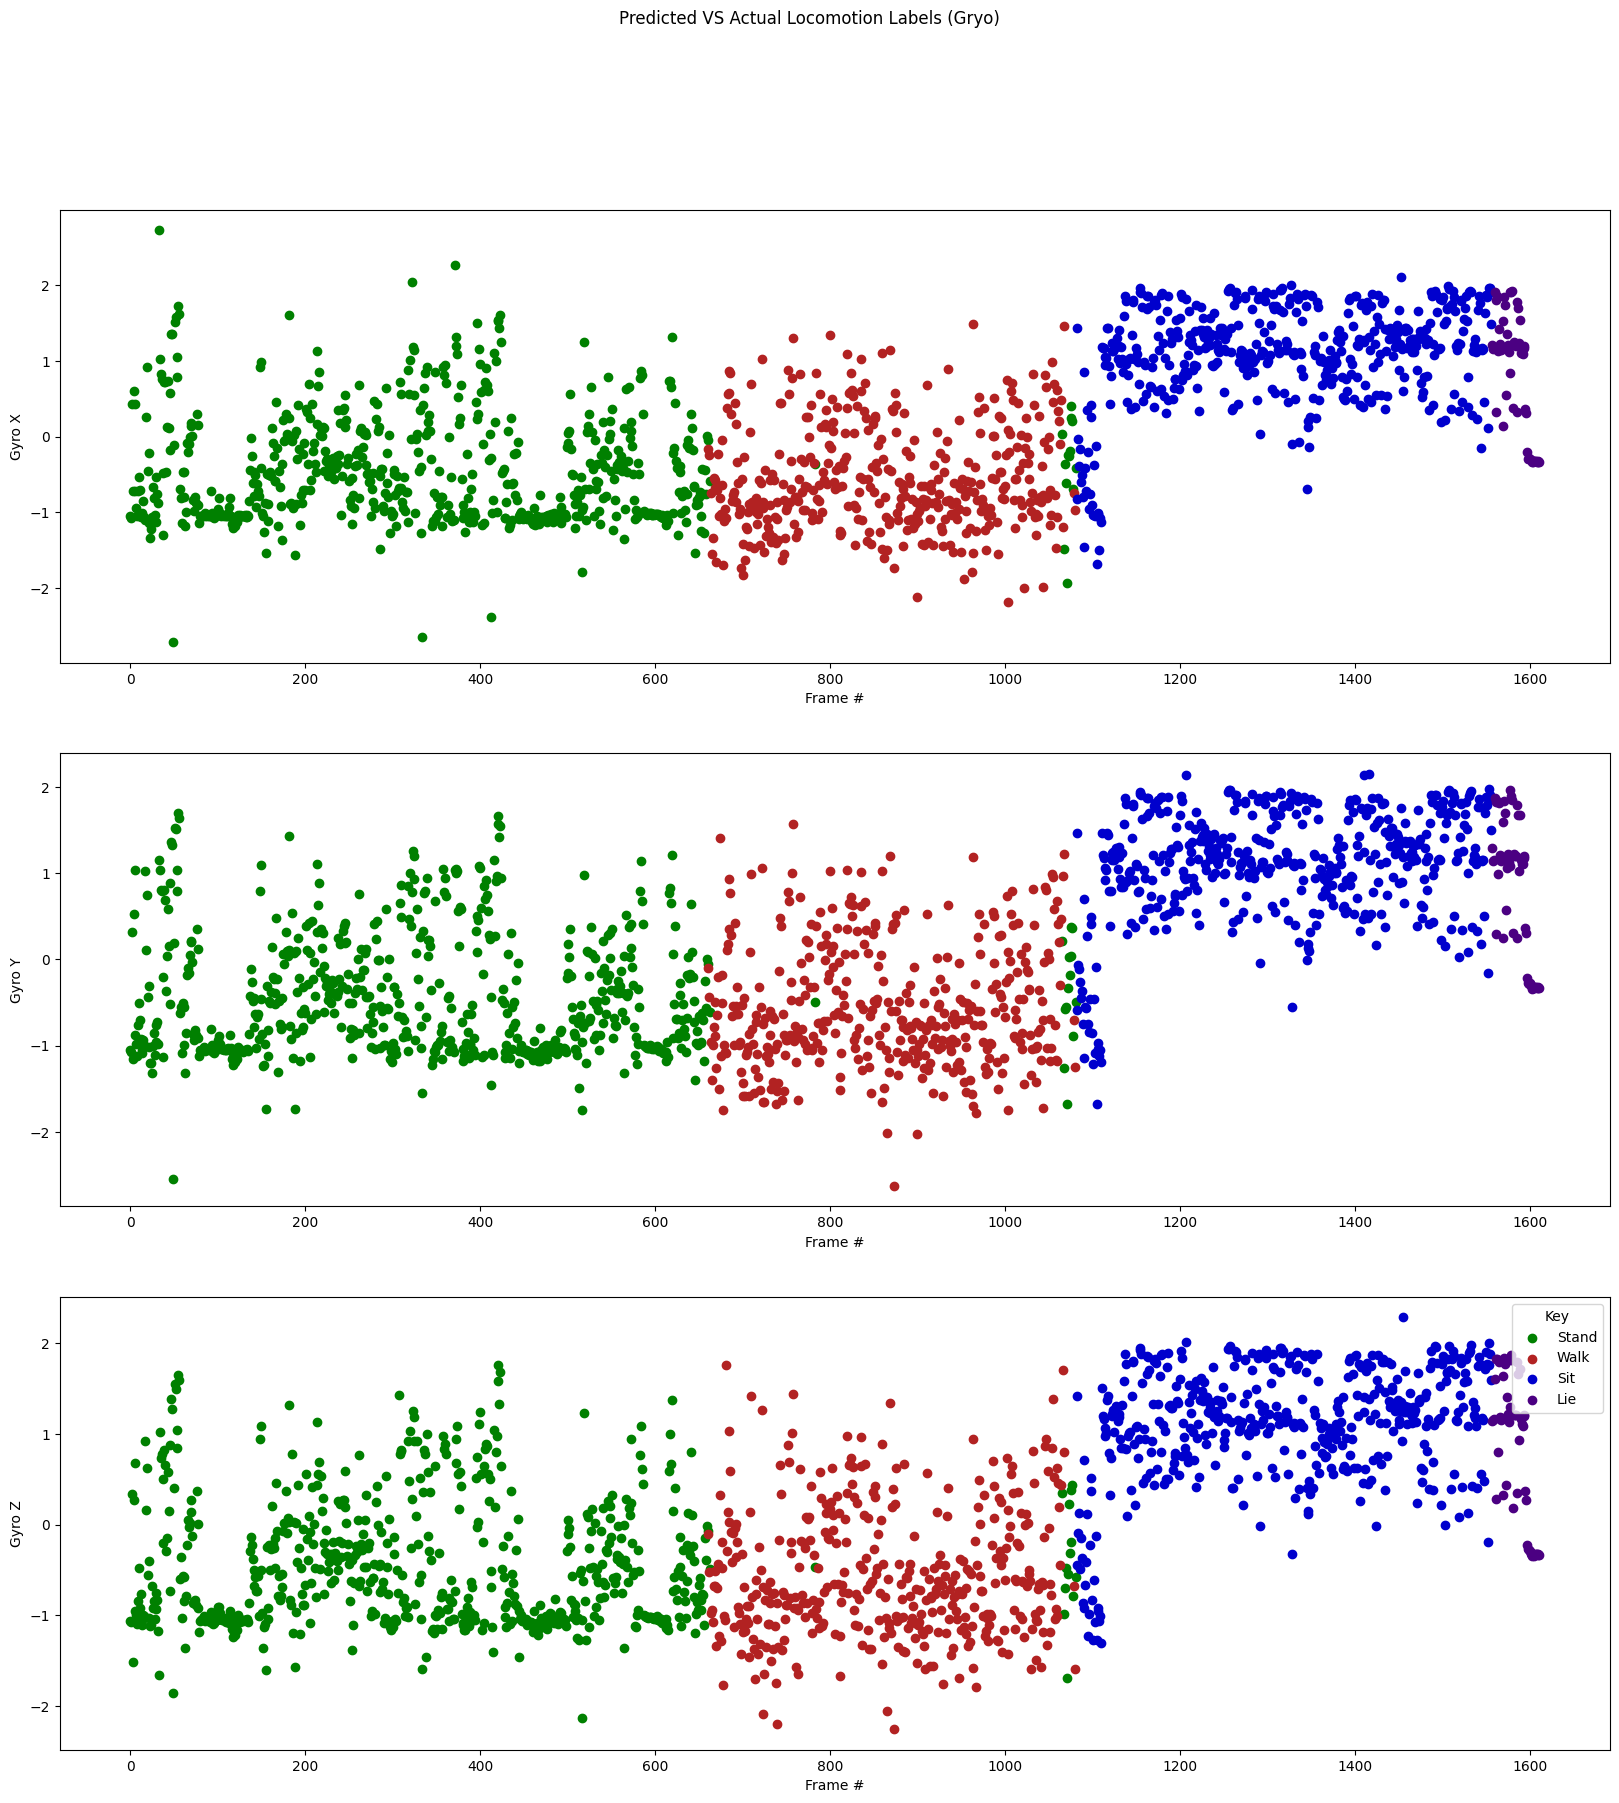

In [10]:
#Gryo Plot
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Locomotion Labels (Gryo)')

for key, group in A_G_M.groupby('Predicted Label'):
    axs[0].scatter(group['Increment'], group['Gyro X'], label=key, c=locomotion_colors[key])
for key, group in A_G_M.groupby('Predicted Label'):
    axs[1].scatter(group['Increment'], group['Gyro Y'], label=key, c=locomotion_colors[key])
for key, group in A_G_M.groupby('Predicted Label'):
    axs[2].scatter(group['Increment'], group['Gyro Z'], label=key, c=locomotion_colors[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Gyro X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Gyro Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Gyro Z')
plt.legend(title='Key', loc = "upper right", labels= ["Stand", "Walk", "Sit", "Lie"])

# Show the plot
plt.show()

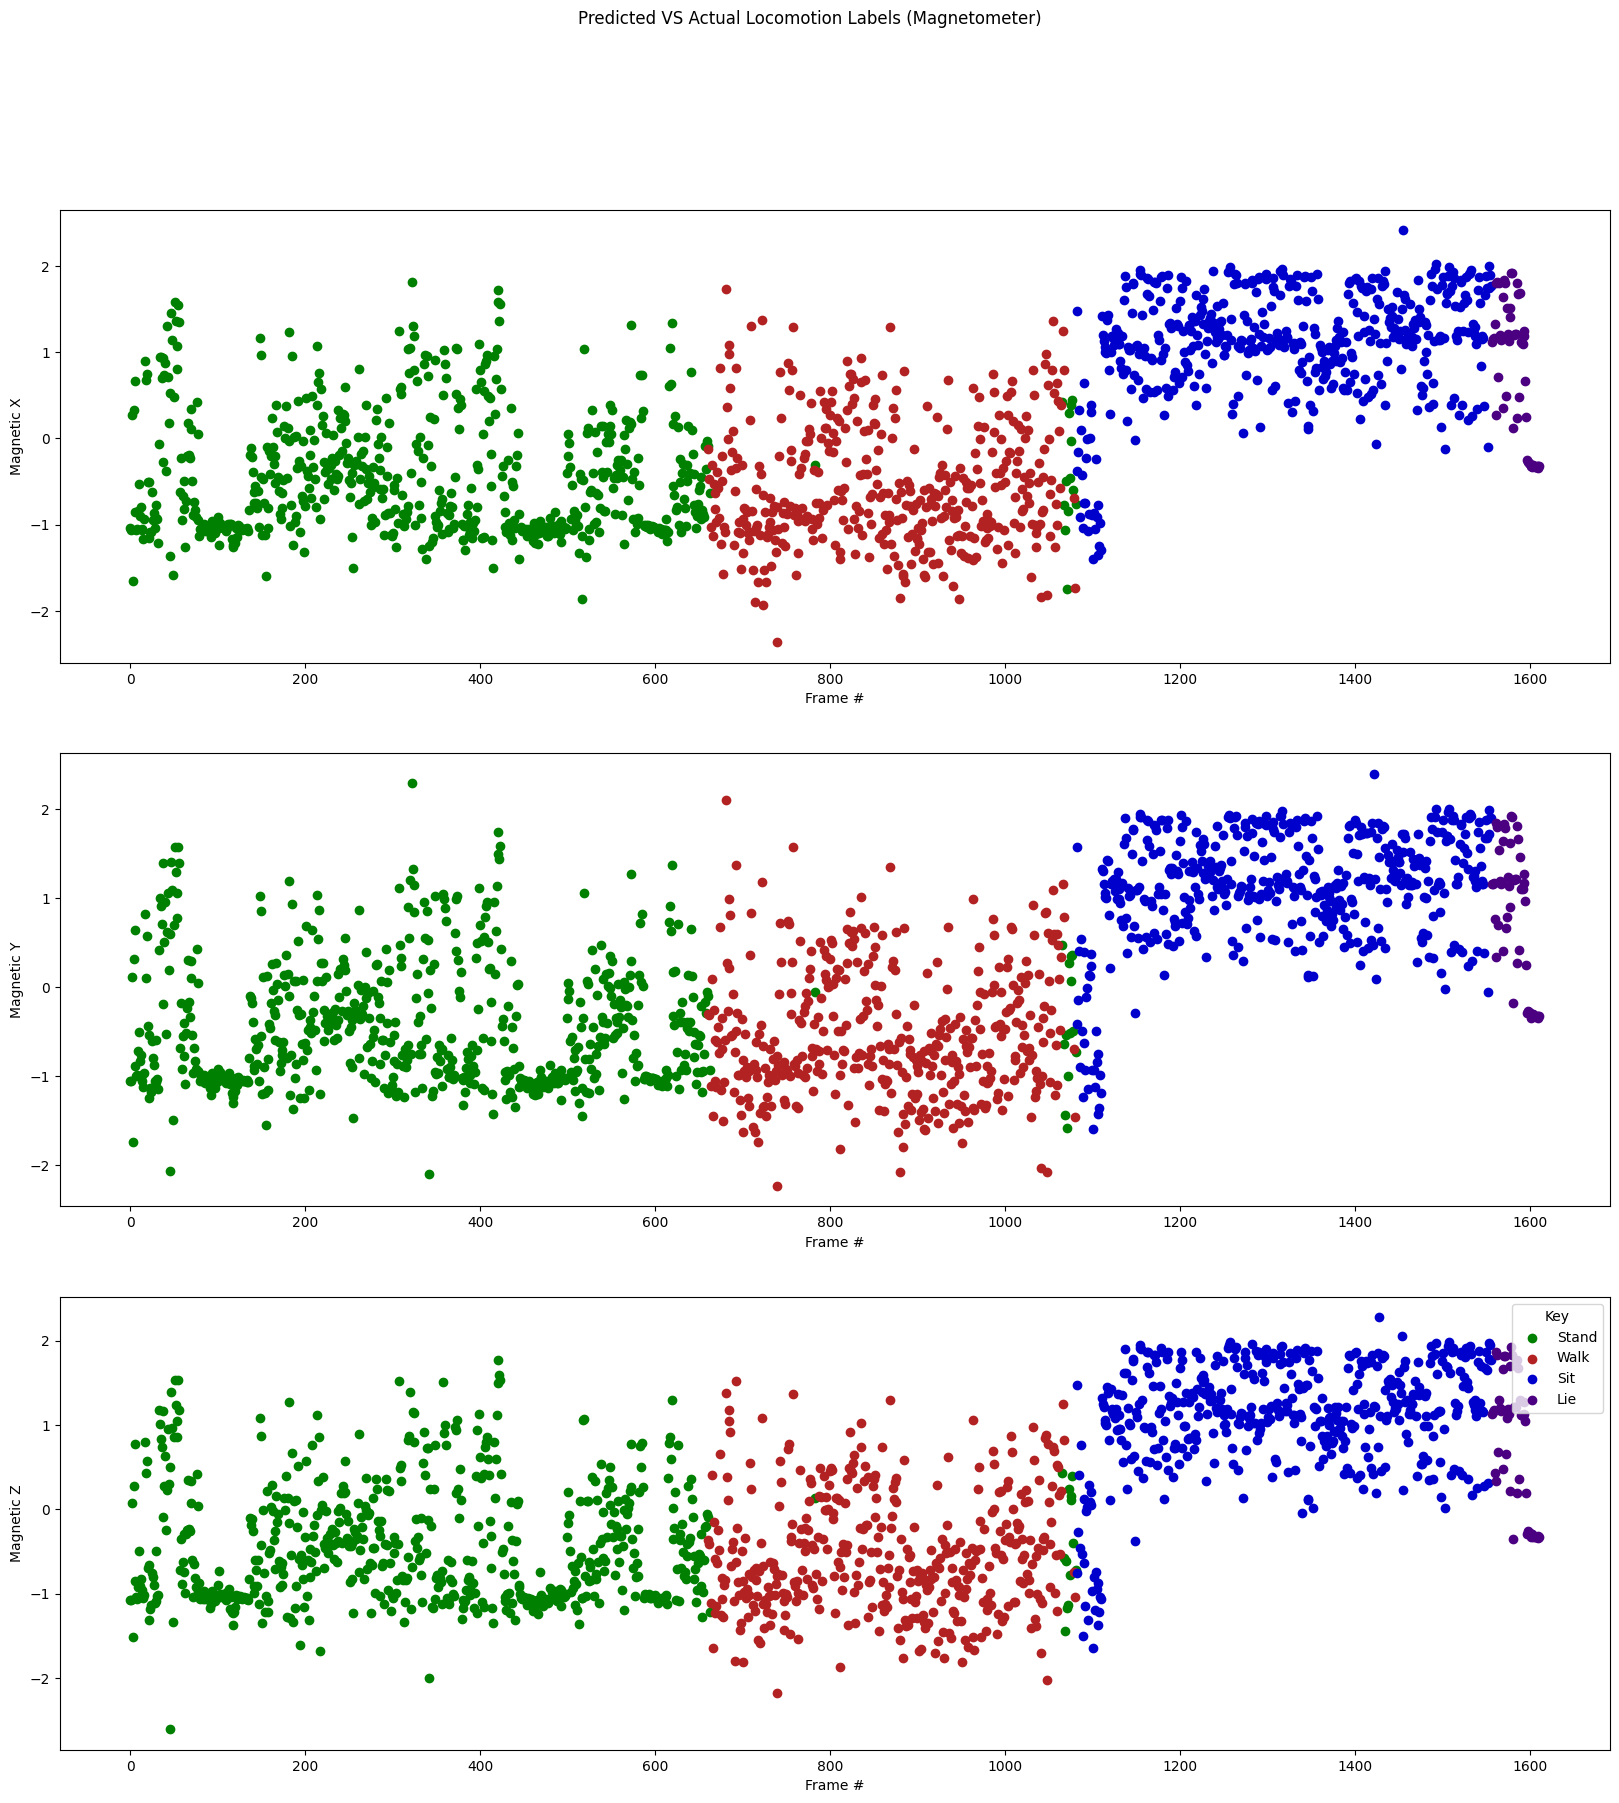

In [11]:
#Magnetic Plot
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Locomotion Labels (Magnetometer)')

for key, group in A_G_M.groupby('Predicted Label'):
    axs[0].scatter(group['Increment'], group['Magnetic X'], label=key, c=locomotion_colors[key])
for key, group in A_G_M.groupby('Predicted Label'):
    axs[1].scatter(group['Increment'], group['Magnetic Y'], label=key, c=locomotion_colors[key])
for key, group in A_G_M.groupby('Predicted Label'):
    axs[2].scatter(group['Increment'], group['Magnetic Z'], label=key, c=locomotion_colors[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Magnetic X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Magnetic Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Magnetic Z')
plt.legend(title='Key', loc = "upper right", labels= ["Stand", "Walk", "Sit", "Lie"])

# Show the plot
plt.show()

### Accuracy Plots

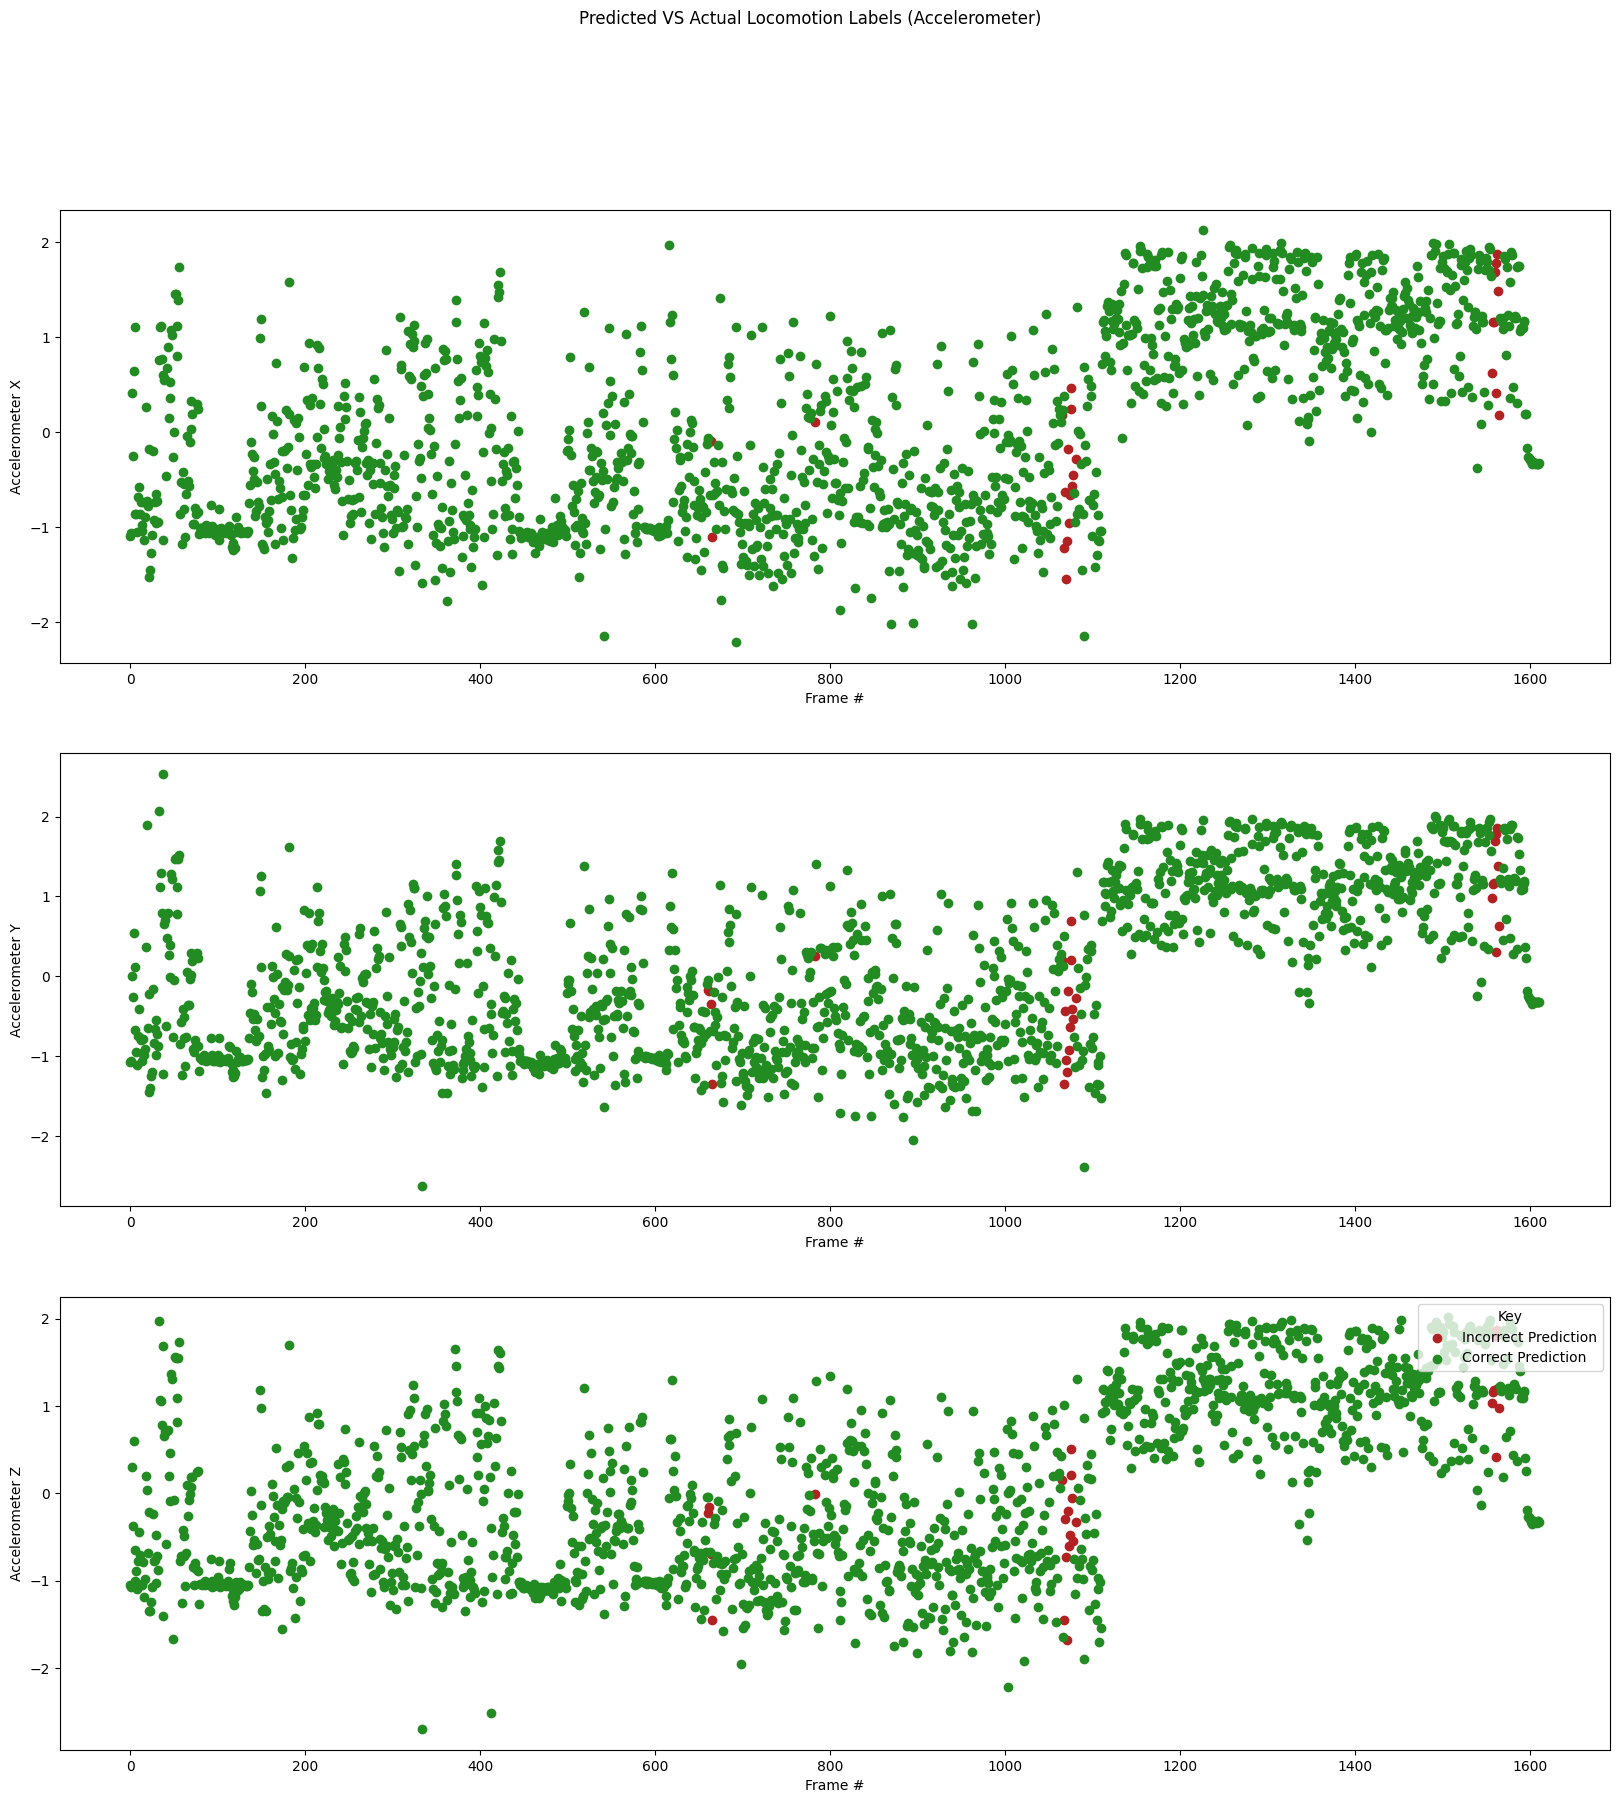

In [12]:
#create color coding keys
Label_Accurracy = {0 :'firebrick', 1 :'forestgreen'}
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Locomotion Labels (Accelerometer)')

#Accelerometer Plot
for key, group in A_G_M.groupby('Label Accuracy'):
    axs[0].scatter(group['Increment'], group['Accelerometer X'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M.groupby('Label Accuracy'):
    axs[1].scatter(group['Increment'], group['Accelerometer Y'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M.groupby('Label Accuracy'):
    axs[2].scatter(group['Increment'], group['Accelerometer Z'], label=key, c=Label_Accurracy[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Accelerometer X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Accelerometer Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Accelerometer Z')
plt.legend(title='Key', loc = "upper right", labels= ["Incorrect Prediction", "Correct Prediction"])

# Show the plot
plt.show()

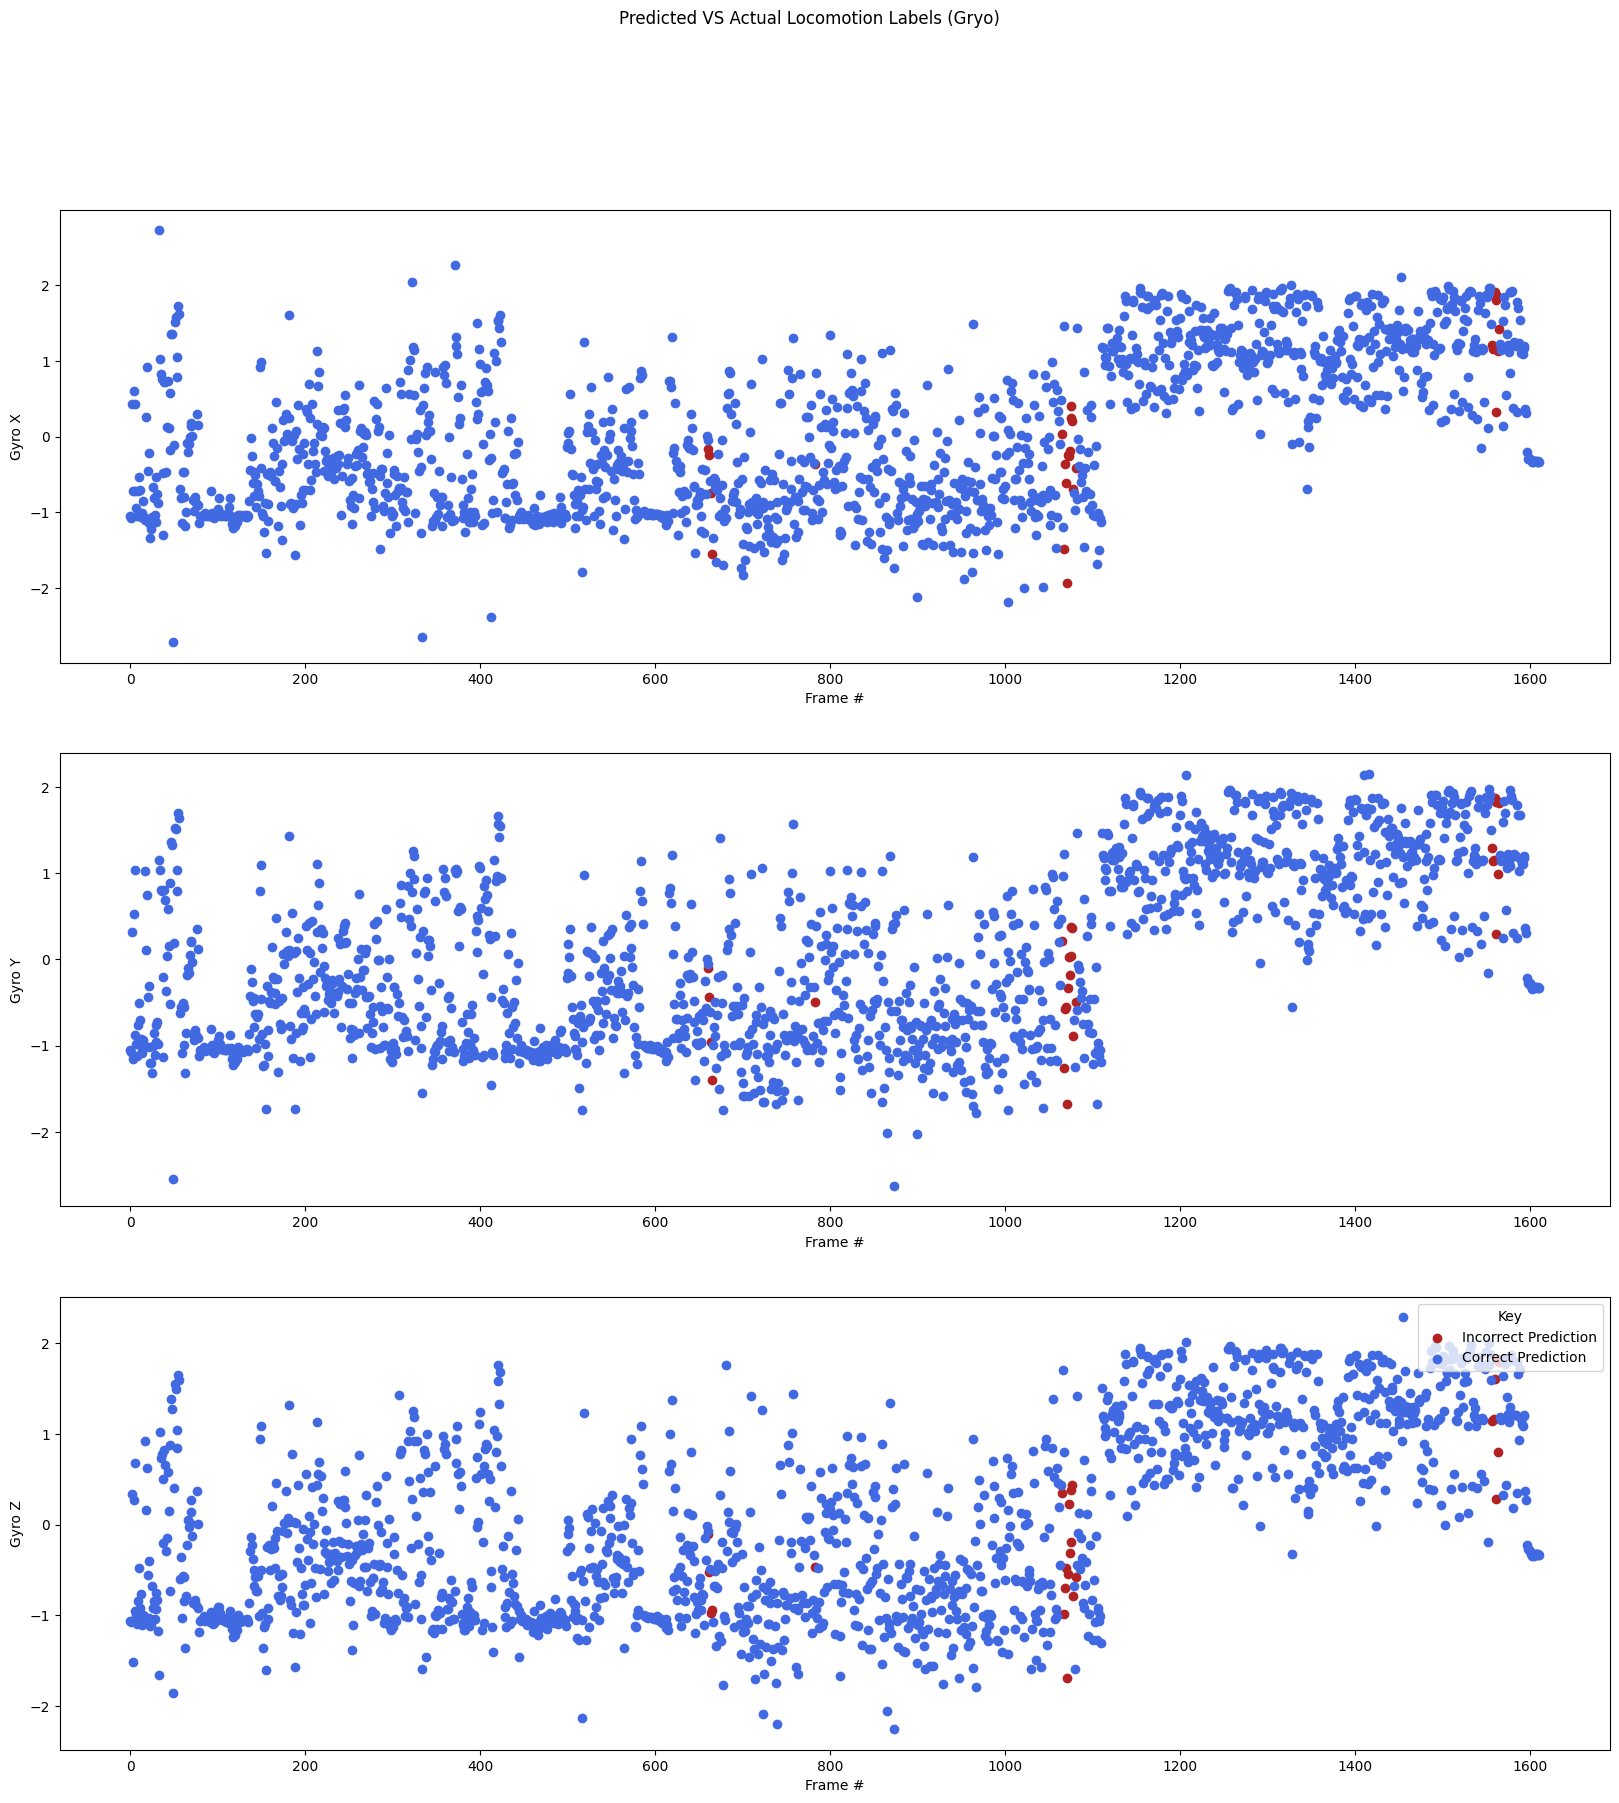

In [13]:
#Gryo Plot
Label_Accurracy = {0 :'firebrick', 1 :'royalblue'}
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Locomotion Labels (Gryo)')

for key, group in A_G_M.groupby('Label Accuracy'):
    axs[0].scatter(group['Increment'], group['Gyro X'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M.groupby('Label Accuracy'):
    axs[1].scatter(group['Increment'], group['Gyro Y'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M.groupby('Label Accuracy'):
    axs[2].scatter(group['Increment'], group['Gyro Z'], label=key, c=Label_Accurracy[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Gyro X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Gyro Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Gyro Z')
plt.legend(title='Key', loc = "upper right", labels= ["Incorrect Prediction", "Correct Prediction"])

# Show the plot
plt.show()

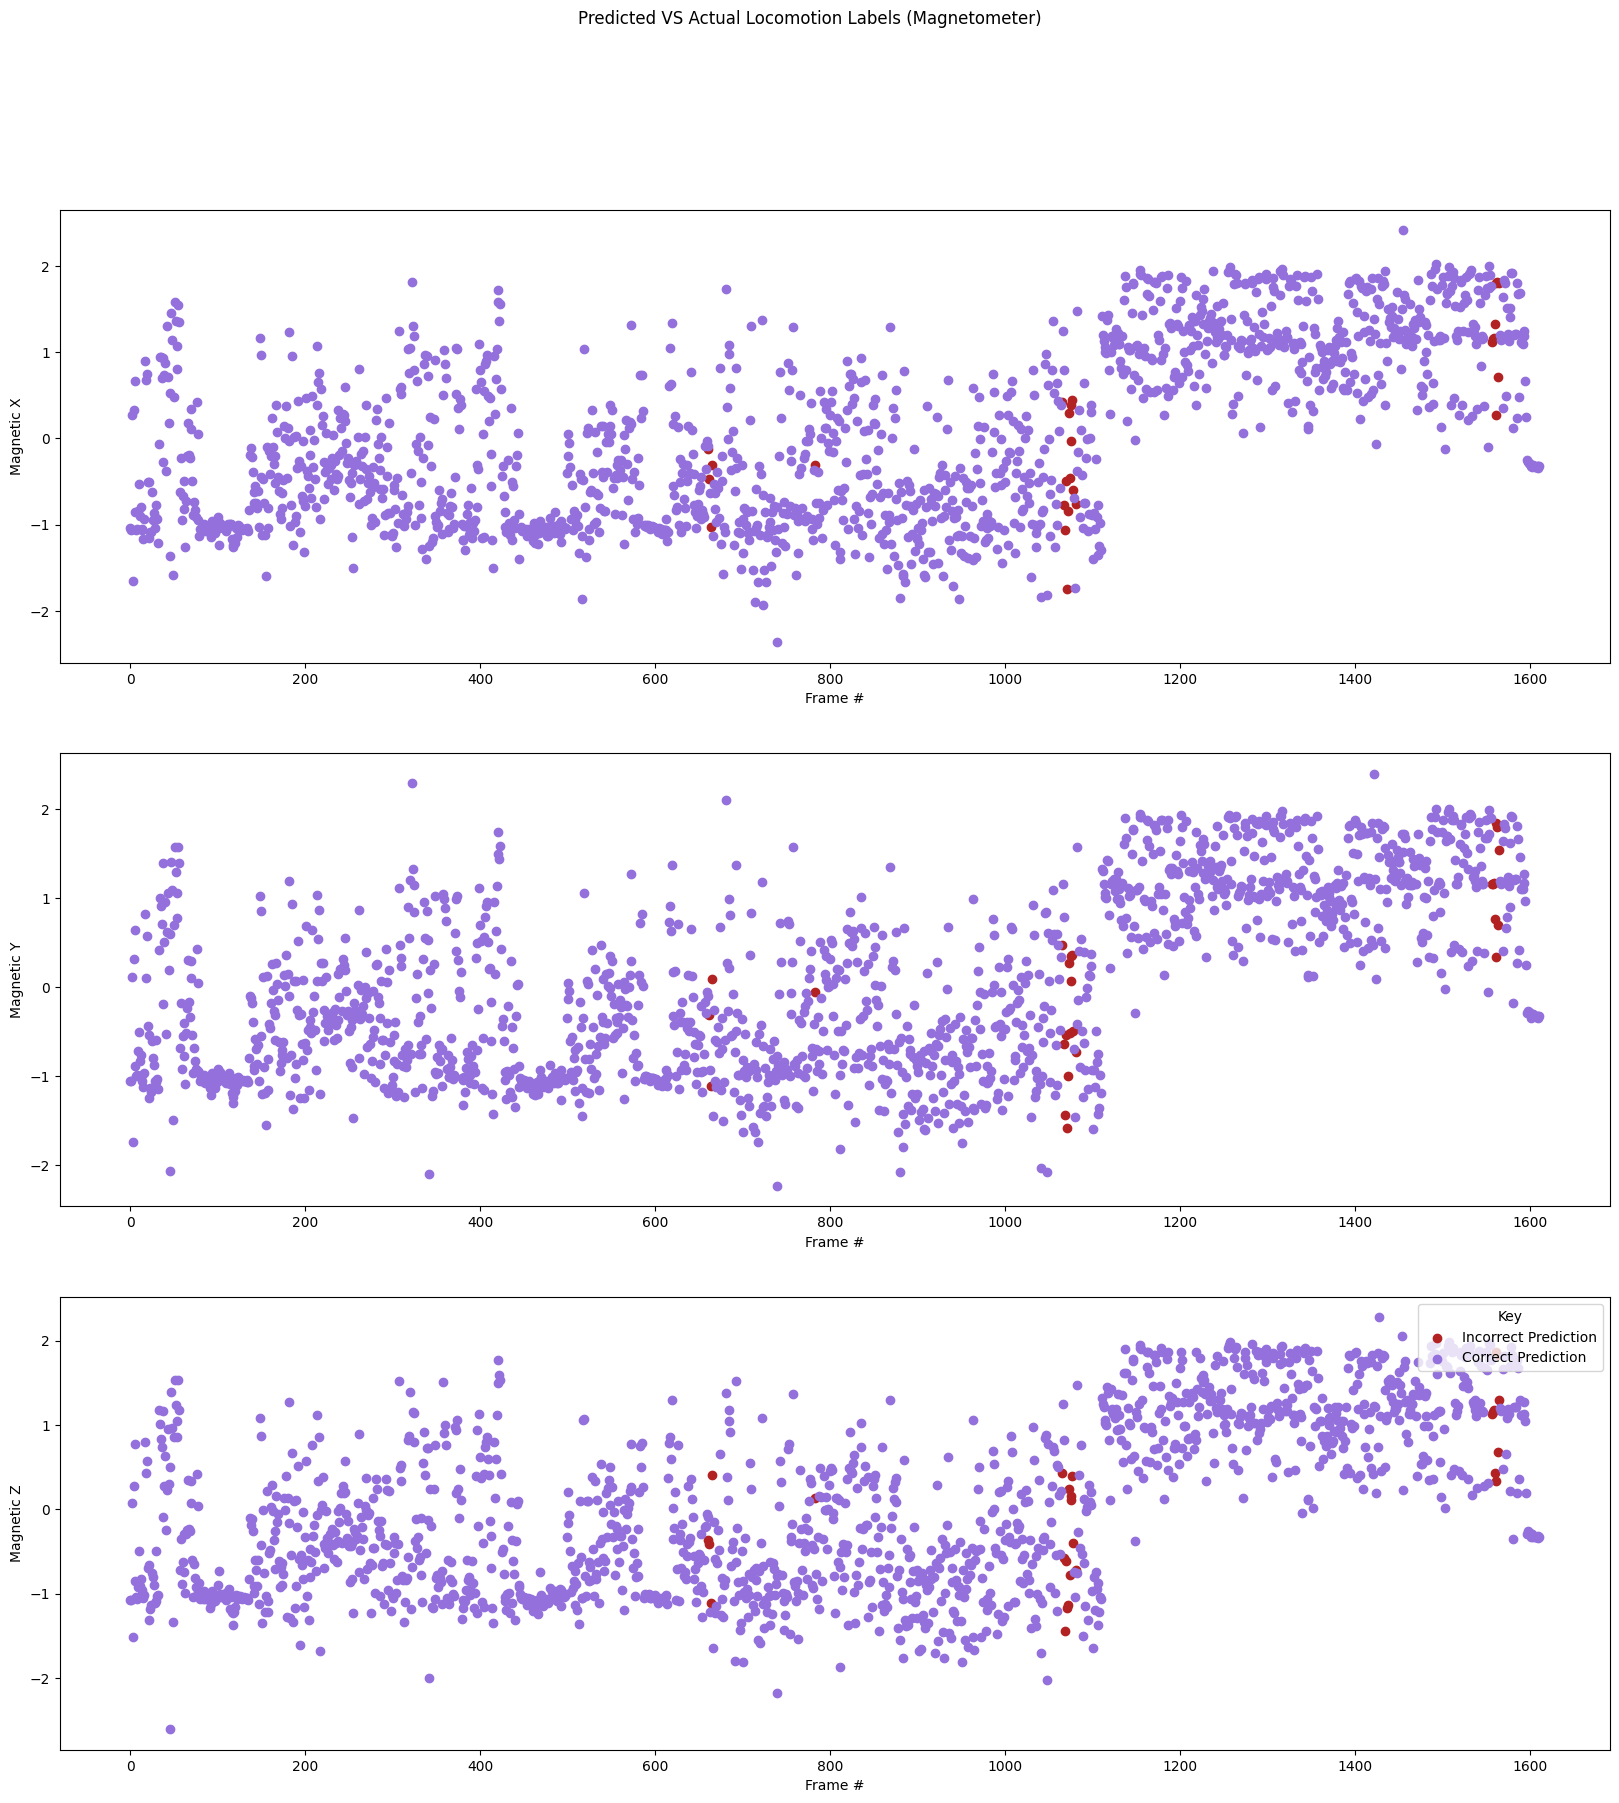

In [14]:
#Magnetic Plot
Label_Accurracy = {0 :'firebrick', 1 :'mediumpurple'}
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Locomotion Labels (Magnetometer)')

for key, group in A_G_M.groupby('Label Accuracy'):
    axs[0].scatter(group['Increment'], group['Magnetic X'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M.groupby('Label Accuracy'):
    axs[1].scatter(group['Increment'], group['Magnetic Y'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M.groupby('Label Accuracy'):
    axs[2].scatter(group['Increment'], group['Magnetic Z'], label=key, c=Label_Accurracy[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Magnetic X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Magnetic Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Magnetic Z')
plt.legend(title='Key', loc = "upper right", labels= ["Incorrect Prediction", "Correct Prediction"])

# Show the plot
plt.show()

## **Arm Motion Test Set Data Assessment**

In [15]:
#Create a COPY of the dataset for training Arm Motions. This is because Cleaning Locomotion 0 rows could remove Arm Motion Rows
Accelerometer_Gyro_data_arm = Accelerometer_Gyro_data.copy()

#Remove all of the NaN data plots that appear do not have an associated motion (Locomotion = 0)
Accelerometer_Gyro_data_arm.drop(Accelerometer_Gyro_data_arm.loc[Accelerometer_Gyro_data_arm['Arm Motion']==0].index, inplace=True)

#Remove NaN Accelerometer and Gyro rows (rows without measurable motion data)
Accelerometer_Gyro_data_arm.drop(Accelerometer_Gyro_data_arm.loc[Accelerometer_Gyro_data_arm['Accelerometer X (mGal)']=='NaN'].index, inplace=True)

Accelerometer_Gyro_data_arm.head()

#info of the dataset for reference
#balance data
Accelerometer_Gyro_data_arm['Accelerometer X (mGal)'] = Accelerometer_Gyro_data_arm['Accelerometer X (mGal)'].astype('float')
Accelerometer_Gyro_data_arm['Accelerometer Y (mGal)'] = Accelerometer_Gyro_data_arm['Accelerometer Y (mGal)'].astype('float')
Accelerometer_Gyro_data_arm['Accelerometer Z (mGal)'] = Accelerometer_Gyro_data_arm['Accelerometer Z (mGal)'].astype('float')

Accelerometer_Gyro_data_arm['Gyro X'] = Accelerometer_Gyro_data_arm['Gyro X'].astype('float')
Accelerometer_Gyro_data_arm['Gyro Y'] = Accelerometer_Gyro_data_arm['Gyro Y'].astype('float')
Accelerometer_Gyro_data_arm['Gyro Z'] = Accelerometer_Gyro_data_arm['Gyro Z'].astype('float')

Accelerometer_Gyro_data_arm['Magnetic X'] = Accelerometer_Gyro_data_arm['Magnetic X'].astype('float')
Accelerometer_Gyro_data_arm['Magnetic Y'] = Accelerometer_Gyro_data_arm['Magnetic Y'].astype('float')
Accelerometer_Gyro_data_arm['Magnetic Z'] = Accelerometer_Gyro_data_arm['Magnetic Z'].astype('float')

#reference of this datatype
Accelerometer_Gyro_data_arm.info()

activities_arm = Accelerometer_Gyro_data_arm['Arm Motion'].value_counts().index

Accelerometer_Gyro_data_arm['Arm Motion'].value_counts()

#balance dataframe so that each activity has the same number of instances
Min_Value = Accelerometer_Gyro_data_arm['Arm Motion'].value_counts()
Min_Value = Min_Value[402]
# In Arm Motion Data:
'''401   -   LL_Right_Arm   -   unlock
402   -   LL_Right_Arm   -   stir
403   -   LL_Right_Arm   -   lock
404   -   LL_Right_Arm   -   close
405   -   LL_Right_Arm   -   reach
406   -   LL_Right_Arm   -   open
407   -   LL_Right_Arm   -   sip
408   -   LL_Right_Arm   -   clean
409   -   LL_Right_Arm   -   bite
410   -   LL_Right_Arm   -   cut
411   -   LL_Right_Arm   -   spread
412   -   LL_Right_Arm   -   release
413   -   LL_Right_Arm   -   move'''
#unlock  = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 401].copy()
#stir    = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 402].copy()
lock    = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 403].copy()
close   = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 404].copy()
reach   = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 405].copy()
open    = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 406].copy()
sip     = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 407].copy()
#clean   = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 408].copy()
#bite    = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 409].copy()
cut     = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 410].copy()
#spread  = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 411].copy()
release = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 412].copy()
move    = Accelerometer_Gyro_data_arm[Accelerometer_Gyro_data_arm['Arm Motion'] == 413].copy()


Accelerometer_Gyro_Balanced_arm = pd.DataFrame()
Accelerometer_Gyro_Balanced_arm = Accelerometer_Gyro_Balanced_arm.append([close, reach, open, sip,
                                                                         cut,release, move])

Accelerometer_Gyro_Balanced_arm['Arm Motion'].value_counts()

Accelerometer_Gyro_Balanced_arm['Arm Motion'].value_counts()

label = LabelEncoder()
Accelerometer_Gyro_Balanced_arm['Label'] = label.fit_transform(Accelerometer_Gyro_Balanced_arm['Arm Motion'])
label.classes_

#Define X and Y parameters
X_Arm = Accelerometer_Gyro_Balanced_arm[['Accelerometer X (mGal)', 'Accelerometer Y (mGal)', 'Accelerometer Z (mGal)',
                                            'Gyro X', 'Gyro Y', 'Gyro Z',
                                            'Magnetic X', 'Magnetic Y', 'Magnetic Z']]
Y_Arm = Accelerometer_Gyro_Balanced_arm['Label']

#Standardize Data
scaler = StandardScaler()
X_Arm = scaler.fit_transform(X_Arm )

X_Arm_Scale = pd.DataFrame(data = X_Arm, columns = ['Accelerometer X (mGal)', 'Accelerometer Y (mGal)', 'Accelerometer Z (mGal)',
                                                                  'Gyro X', 'Gyro Y', 'Gyro Z',
                                                                  'Magnetic X', 'Magnetic Y', 'Magnetic Z'])
X_Arm_Scale['Label'] = Y_Arm.values
X_Arm_Scale

X_Arm, y_Arm = Get_Frames(X_Arm_Scale, Frame_Size, Hop_Size)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28019 entries, 2428 to 63658
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time (ms)               28019 non-null  int64  
 1   Accelerometer X (mGal)  28019 non-null  float64
 2   Accelerometer Y (mGal)  28019 non-null  float64
 3   Accelerometer Z (mGal)  28019 non-null  float64
 4   Gyro X                  28019 non-null  float64
 5   Gyro Y                  28019 non-null  float64
 6   Gyro Z                  28019 non-null  float64
 7   Magnetic X              28019 non-null  float64
 8   Magnetic Y              28019 non-null  float64
 9   Magnetic Z              28019 non-null  float64
 10  Locomotion              28019 non-null  int64  
 11  Arm Motion              28019 non-null  int64  
 12  Arm Object              28019 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 3.0 MB


<ipython-input-15-5ab7dc42d427>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Accelerometer_Gyro_Balanced_arm = Accelerometer_Gyro_Balanced_arm.append([close, reach, open, sip,


### Confusion Matrix

26/26 [==============================] - 4s 151ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

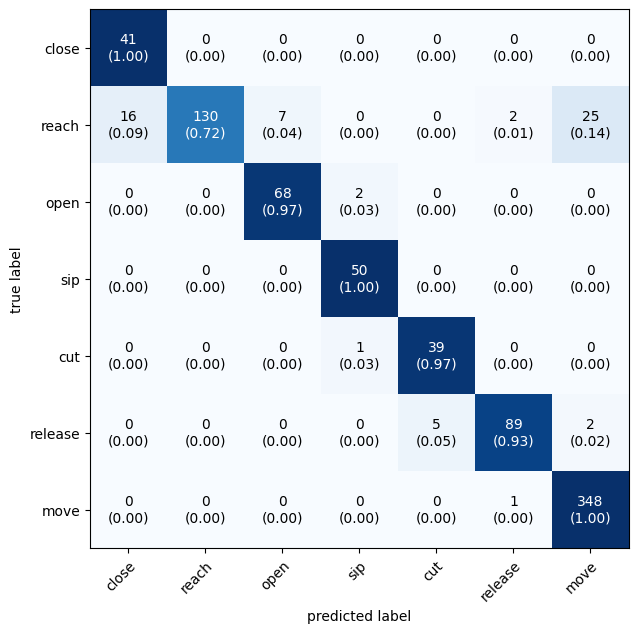

In [16]:
predictions_arm = CNNModel_Test_Arm.predict(X_Arm, verbose = 1)
#np.argmax(predictions, axis=1)

classes_arm=np.argmax(predictions_arm,axis=1)
mat = confusion_matrix(y_Arm, classes_arm)

# Remove rows where all elements are 0
#mat = mat[~np.all(mat == 0, axis=1)]

# Remove columns where all elements are 0
#mat = mat[:, ~np.all(mat == 0, axis=0)]

Arm_Labels = np.array(['close', 'reach', 'open', 'sip','cut','release','move'])
plot_confusion_matrix(conf_mat = mat, show_normed = True, class_names = Arm_Labels, figsize =(7,7))

### Label Plots

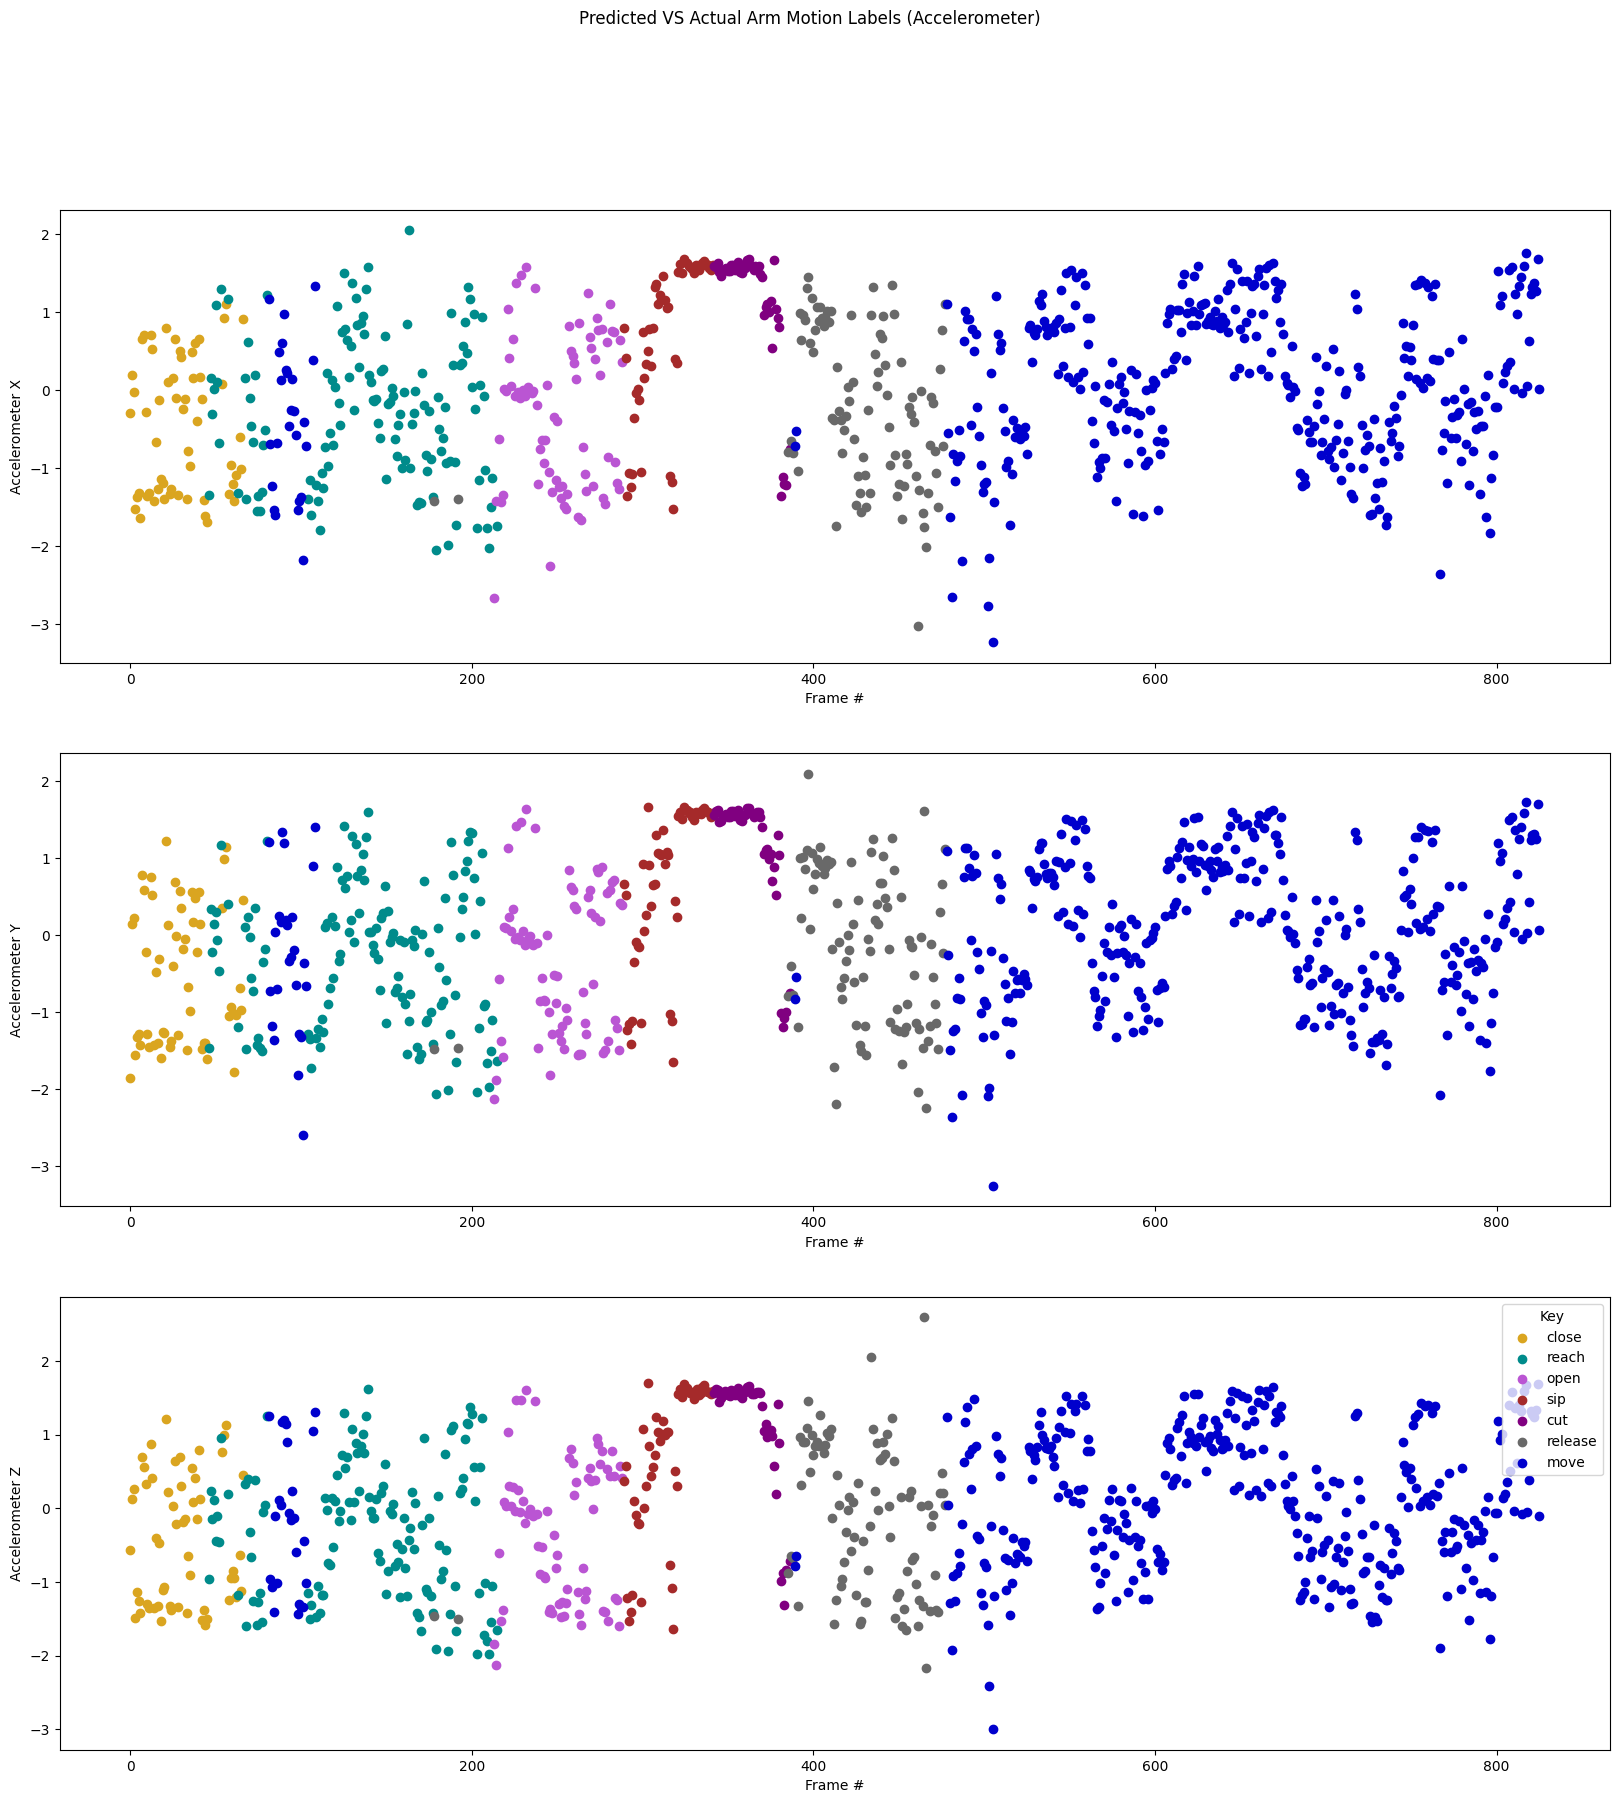

In [17]:
#create color coding keys
motion_colors = {0: 'goldenrod', 1: 'darkcyan', 2: 'mediumorchid', 3: 'brown',  4: 'purple', 5: 'dimgray', 6: 'mediumblue'}

#Create new dataframe
X_values_arm = X_Arm[:, 0]
length_arm = np.arange(len(X_values_arm))
Prediction_values_arm = predictions_arm[:, 0]
A_G_M_arm = pd.DataFrame(X_values_arm)
#define columns
A_G_M_arm.columns= ['Accelerometer X', 'Accelerometer Y', 'Accelerometer Z', 'Gyro X', 'Gyro Y', 'Gyro Z', 'Magnetic X', 'Magnetic Y', 'Magnetic Z']

A_G_M_arm["Actual Label"] = y_Arm
A_G_M_arm["Predicted Label"] = classes_arm

#create new true false column that determines if the actual label was equal to the predicted label
A_G_M_arm['Label Accuracy'] = np.where(A_G_M_arm['Actual Label'] == A_G_M_arm['Predicted Label'], 1, 0)
A_G_M_arm['Increment'] = length_arm
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Arm Motion Labels (Accelerometer)')

for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[0].scatter(group['Increment'], group['Accelerometer X'], label=key, c=motion_colors[key])
for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[1].scatter(group['Increment'], group['Accelerometer Y'], label=key, c=motion_colors[key])
for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[2].scatter(group['Increment'], group['Accelerometer Z'], label=key, c=motion_colors[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Accelerometer X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Accelerometer Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Accelerometer Z')
plt.legend(title='Key', loc = "upper right", labels= ["close", "reach", "open", "sip", "cut", "release", "move"])

# Show the plot
plt.show()

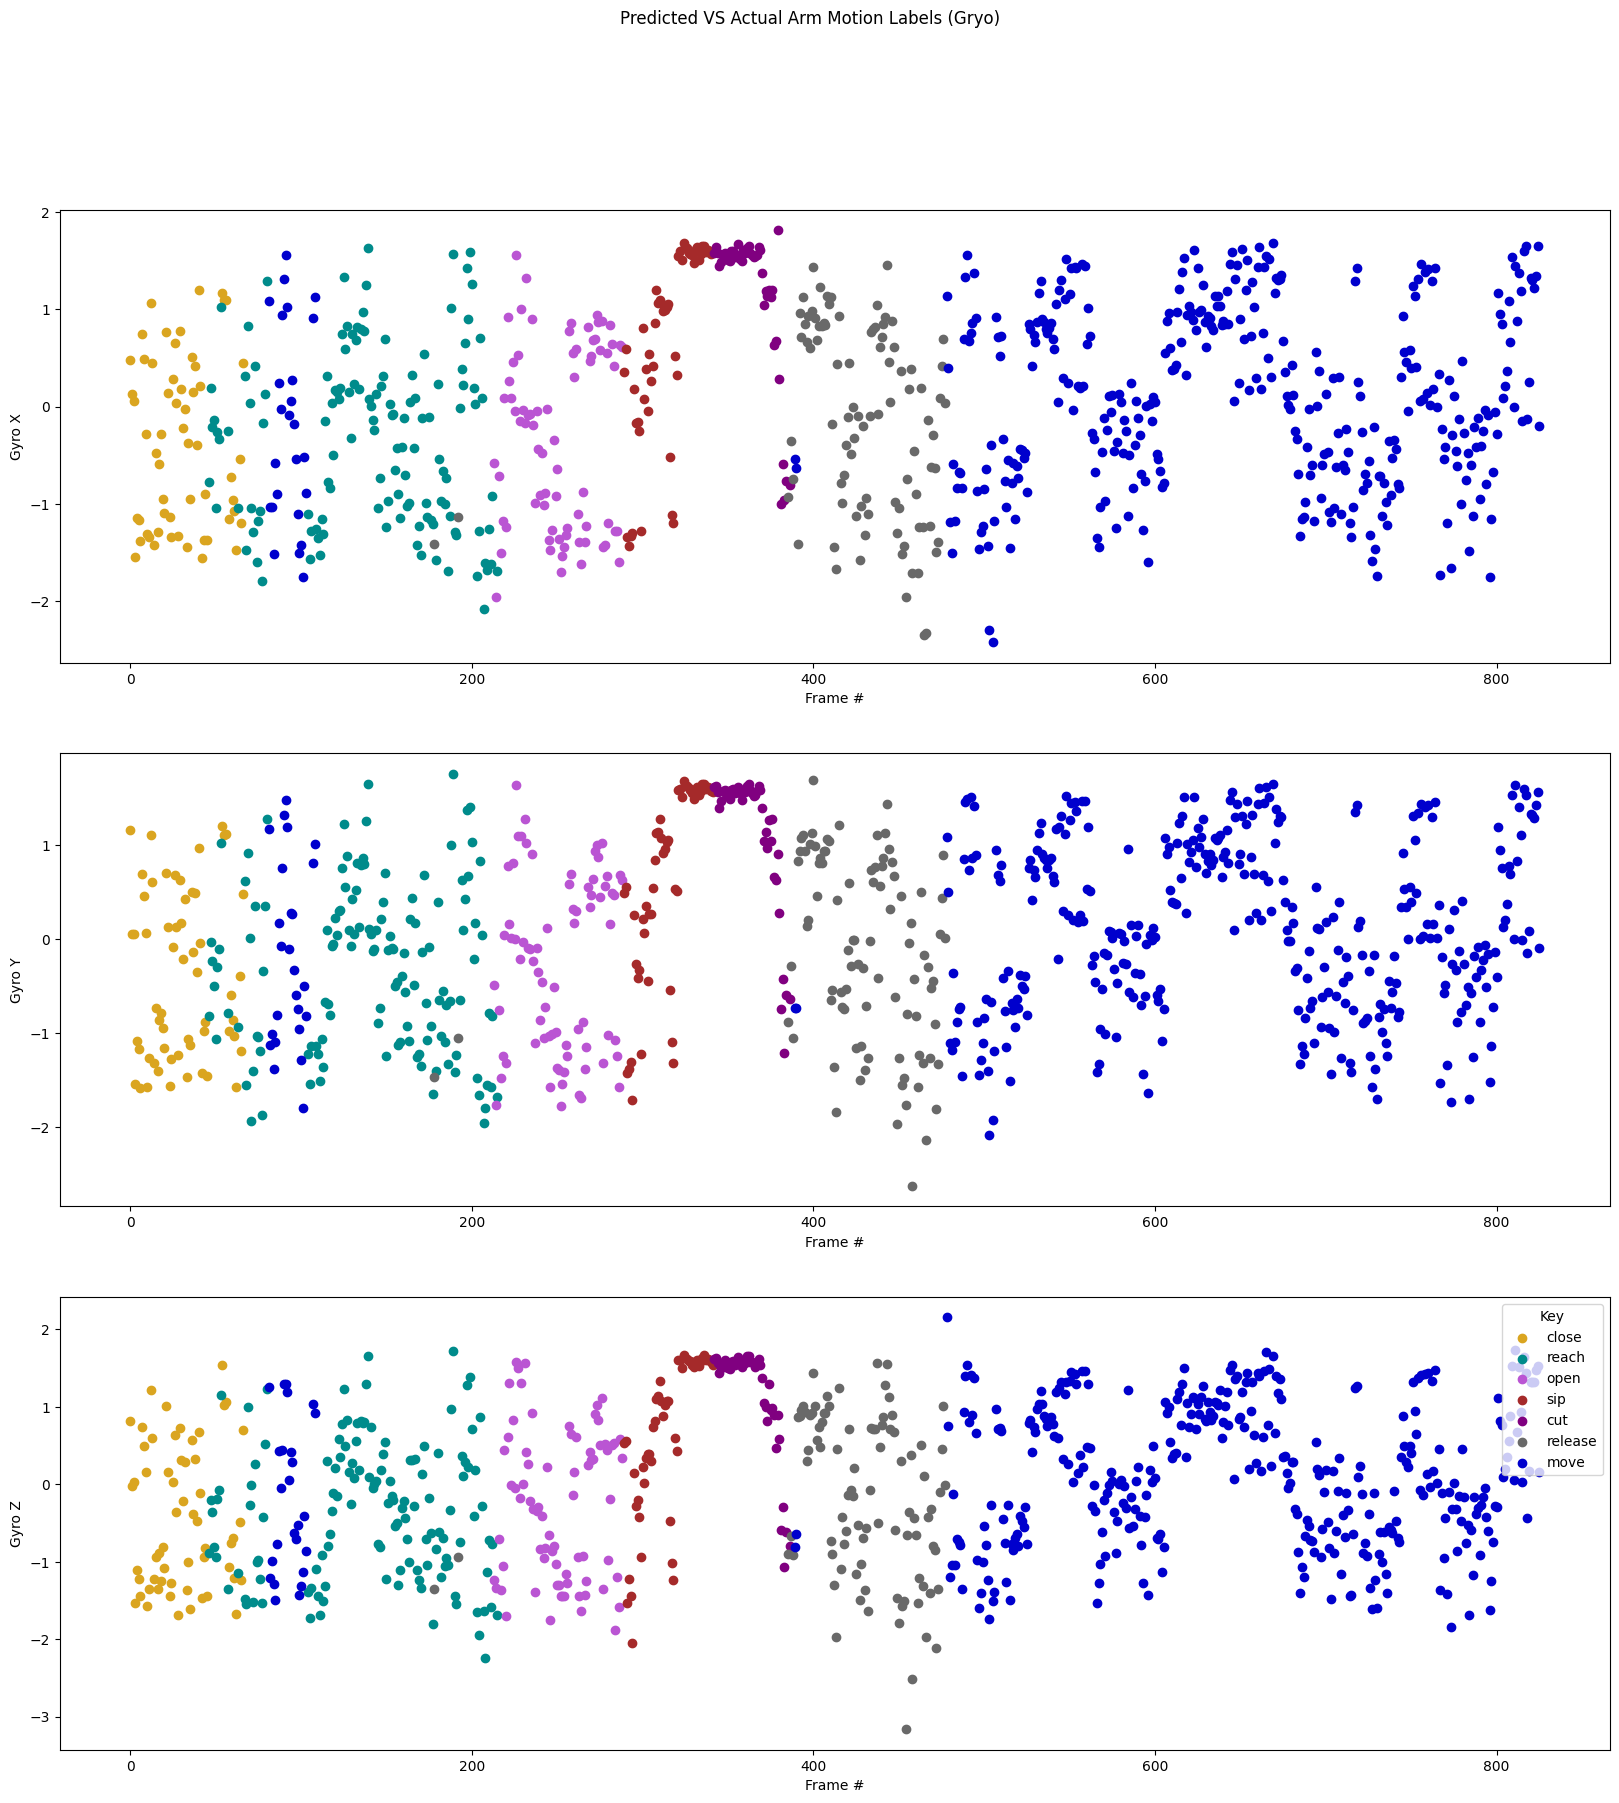

In [18]:
#Gryo Plot
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Arm Motion Labels (Gryo)')

for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[0].scatter(group['Increment'], group['Gyro X'], label=key, c=motion_colors[key])
for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[1].scatter(group['Increment'], group['Gyro Y'], label=key, c=motion_colors[key])
for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[2].scatter(group['Increment'], group['Gyro Z'], label=key, c=motion_colors[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Gyro X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Gyro Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Gyro Z')
plt.legend(title='Key', loc = "upper right", labels= ["close", "reach", "open", "sip", "cut", "release", "move"])

# Show the plot
plt.show()

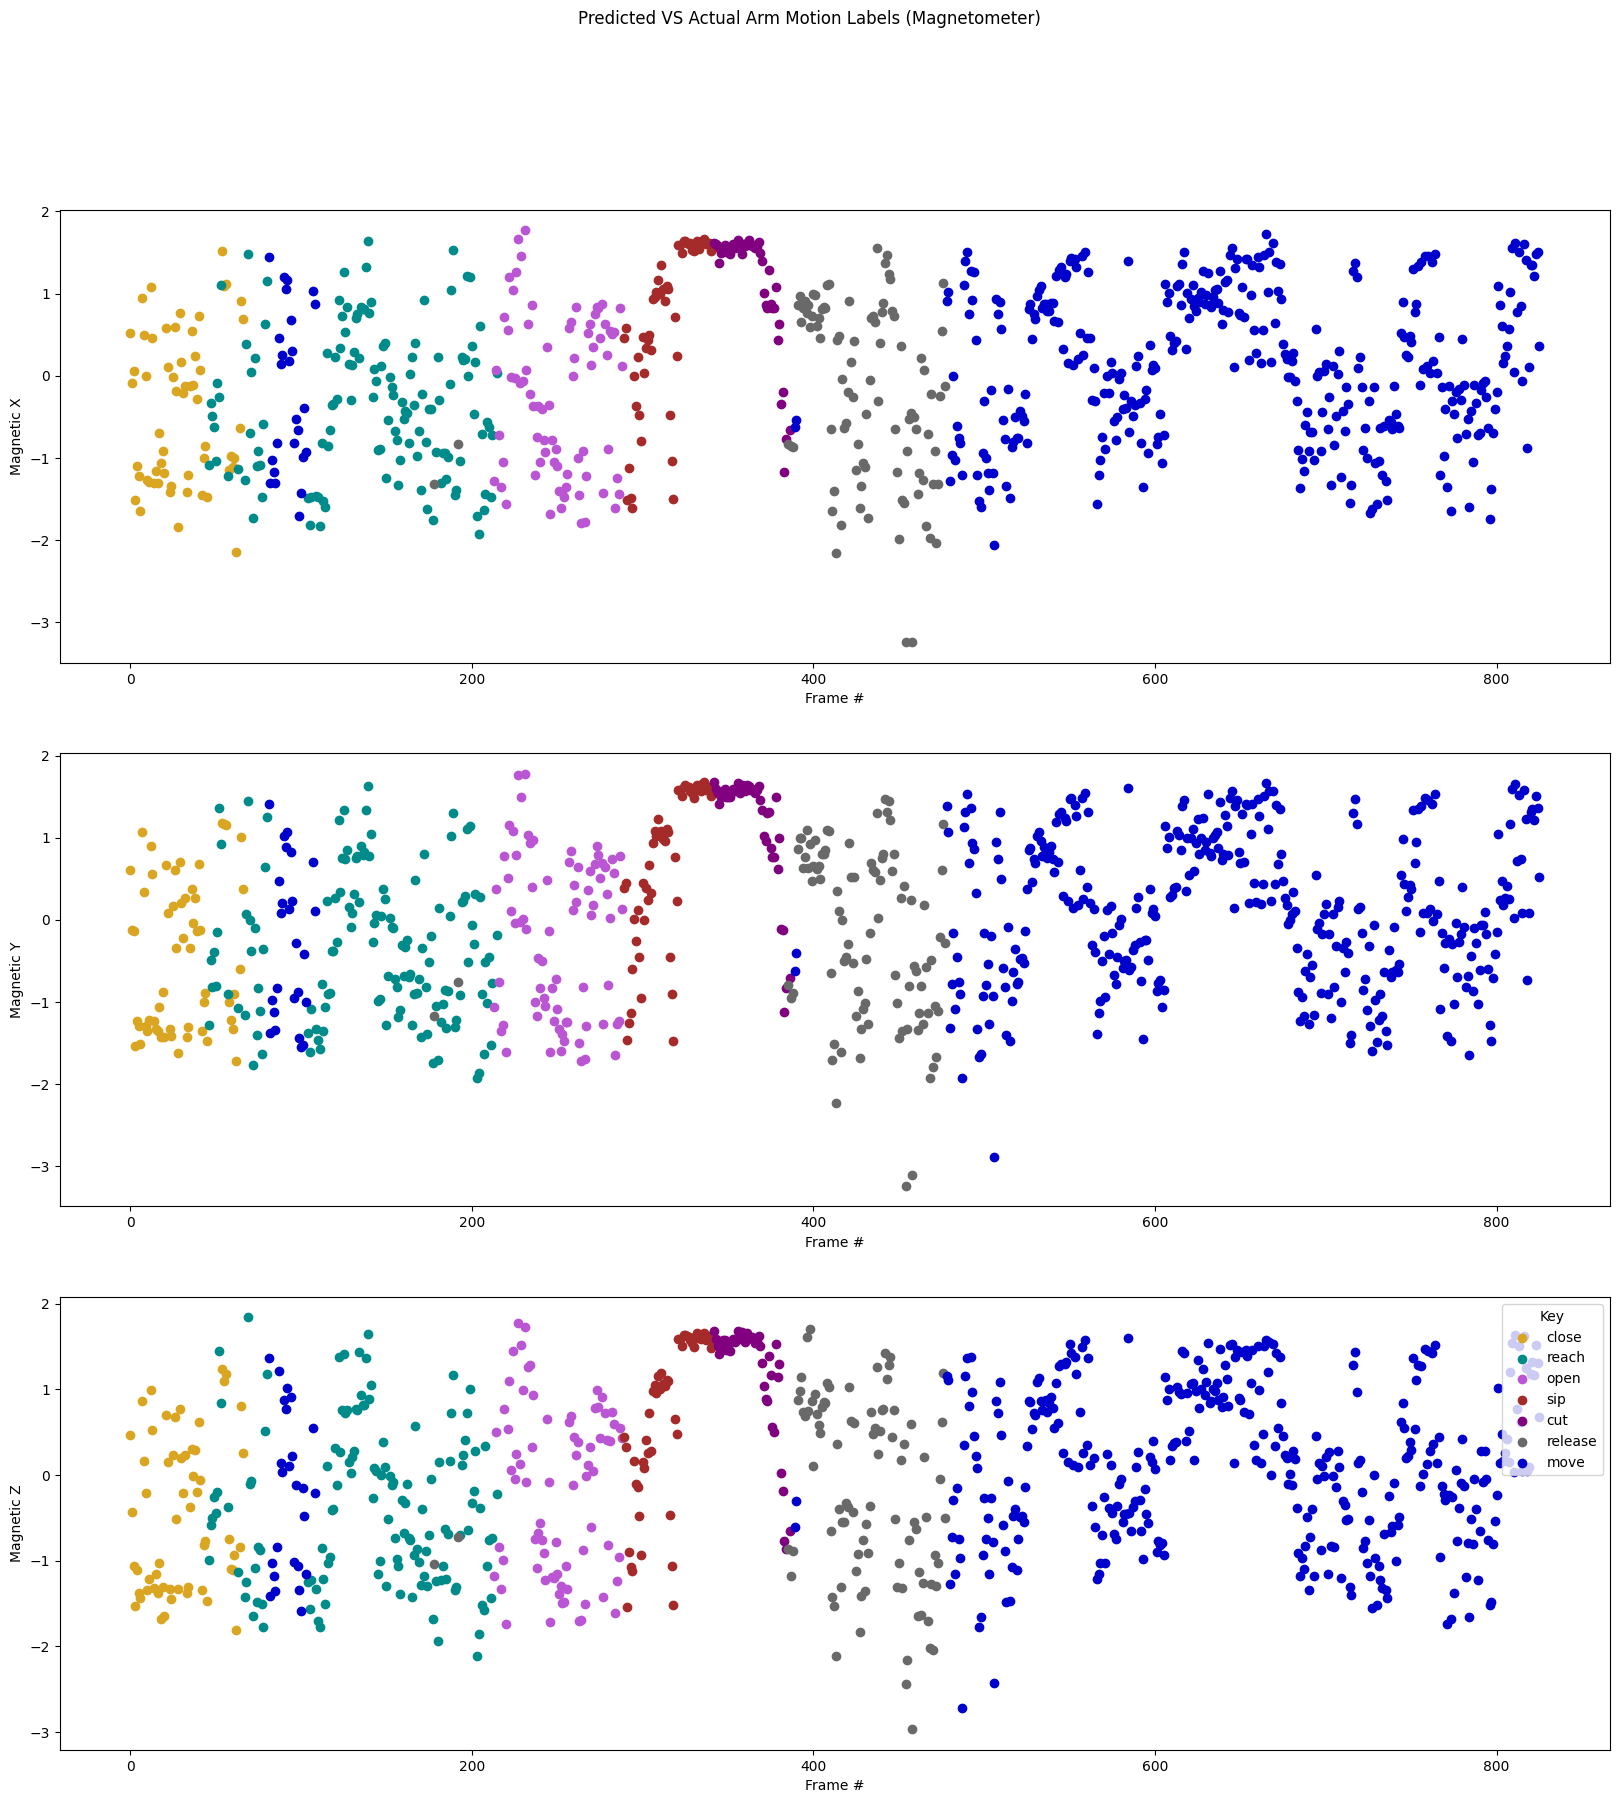

In [19]:
#Magnetic Plot
Label_Accurracy = {0 :'firebrick', 1 :'mediumpurple'}
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Arm Motion Labels (Magnetometer)')

for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[0].scatter(group['Increment'], group['Magnetic X'], label=key, c=motion_colors[key])
for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[1].scatter(group['Increment'], group['Magnetic Y'], label=key, c=motion_colors[key])
for key, group in A_G_M_arm.groupby('Predicted Label'):
    axs[2].scatter(group['Increment'], group['Magnetic Z'], label=key, c=motion_colors[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Magnetic X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Magnetic Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Magnetic Z')
plt.legend(title='Key', loc = "upper right", labels= ["close", "reach", "open", "sip", "cut", "release", "move"])

# Show the plot
plt.show()

### Accuracy Plots

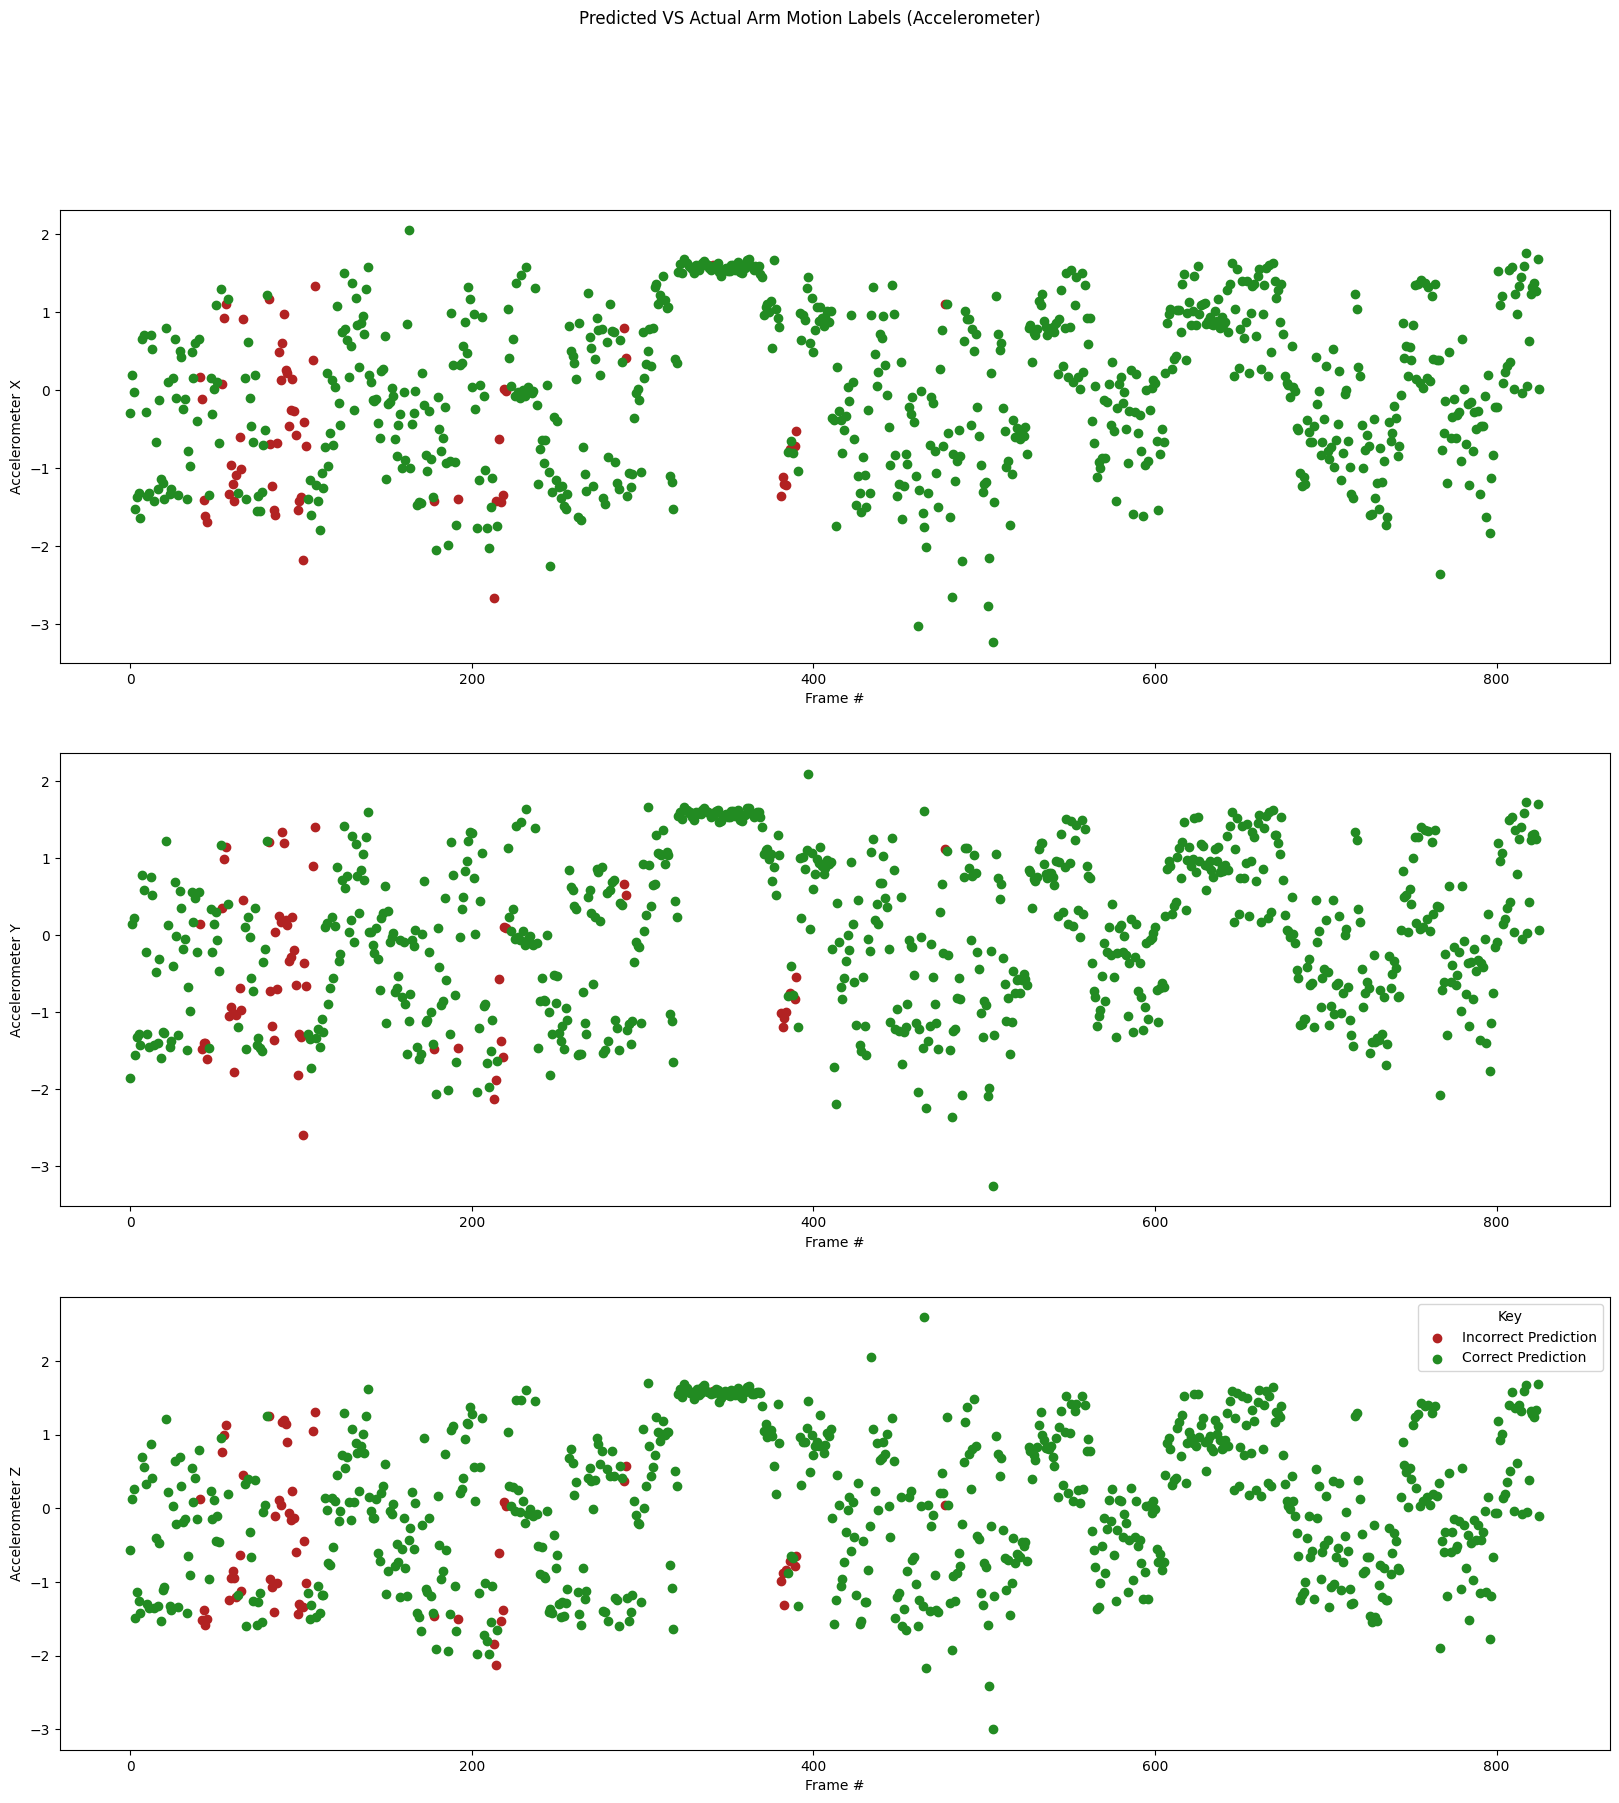

In [20]:
#create color coding keys
Label_Accurracy = {0 :'firebrick', 1 :'forestgreen'}

fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Arm Motion Labels (Accelerometer)')

for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[0].scatter(group['Increment'], group['Accelerometer X'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[1].scatter(group['Increment'], group['Accelerometer Y'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[2].scatter(group['Increment'], group['Accelerometer Z'], label=key, c=Label_Accurracy[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Accelerometer X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Accelerometer Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Accelerometer Z')
plt.legend(title='Key', loc = "upper right", labels= ["Incorrect Prediction", "Correct Prediction"])

# Show the plot
plt.show()

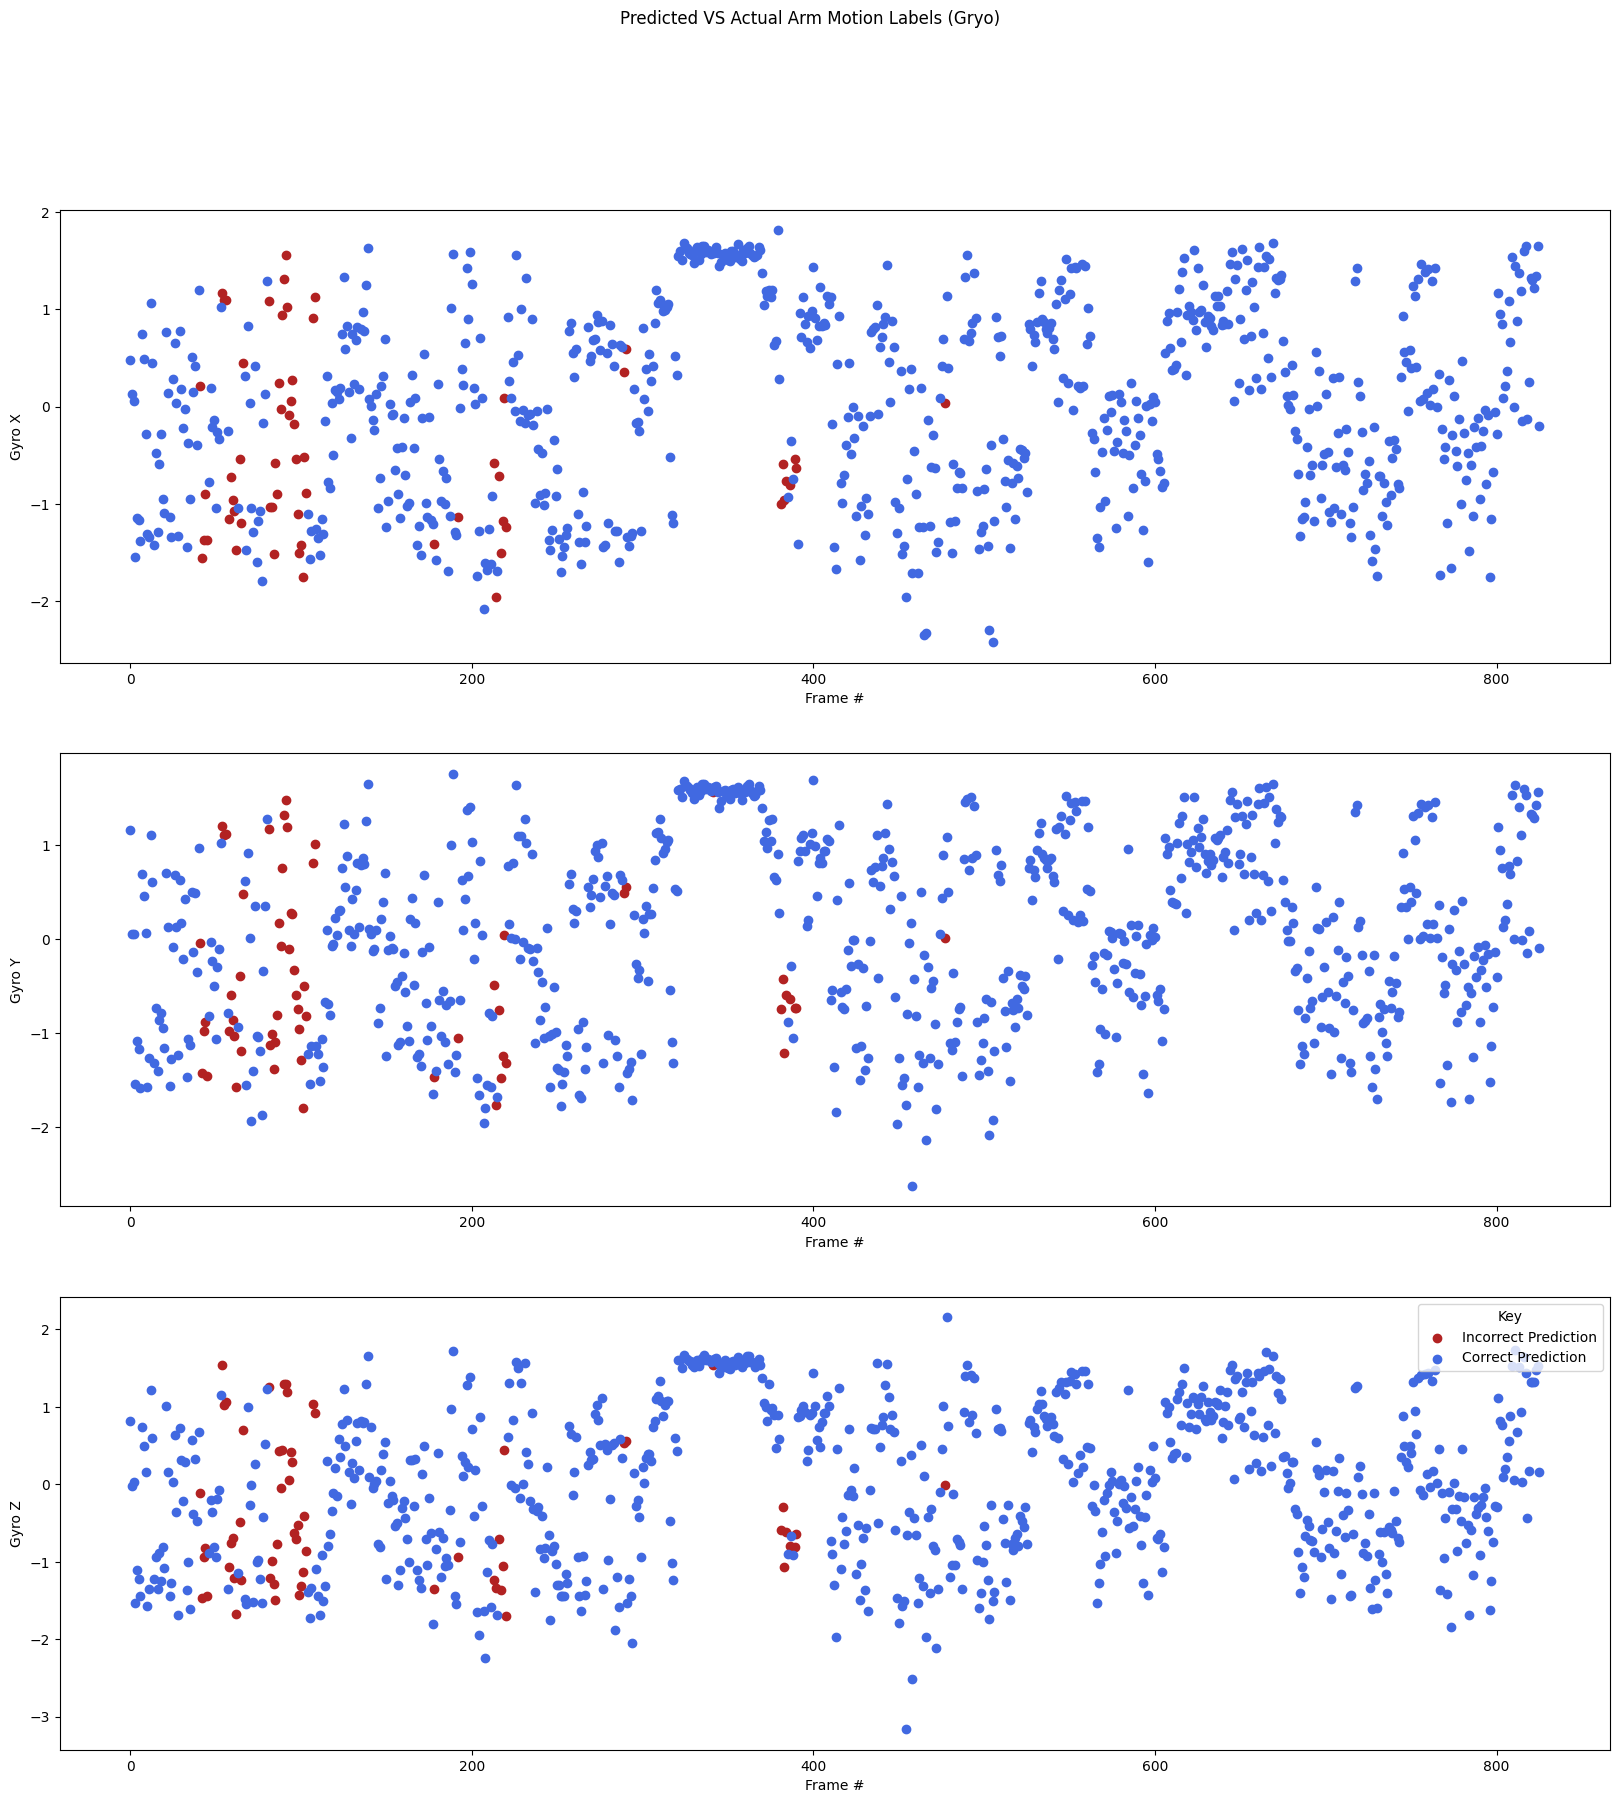

In [21]:
#Gryo Plot
Label_Accurracy = {0 :'firebrick', 1 :'royalblue'}
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Arm Motion Labels (Gryo)')

for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[0].scatter(group['Increment'], group['Gyro X'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[1].scatter(group['Increment'], group['Gyro Y'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[2].scatter(group['Increment'], group['Gyro Z'], label=key, c=Label_Accurracy[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Gyro X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Gyro Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Gyro Z')
plt.legend(title='Key', loc = "upper right", labels= ["Incorrect Prediction", "Correct Prediction"])

# Show the plot
plt.show()

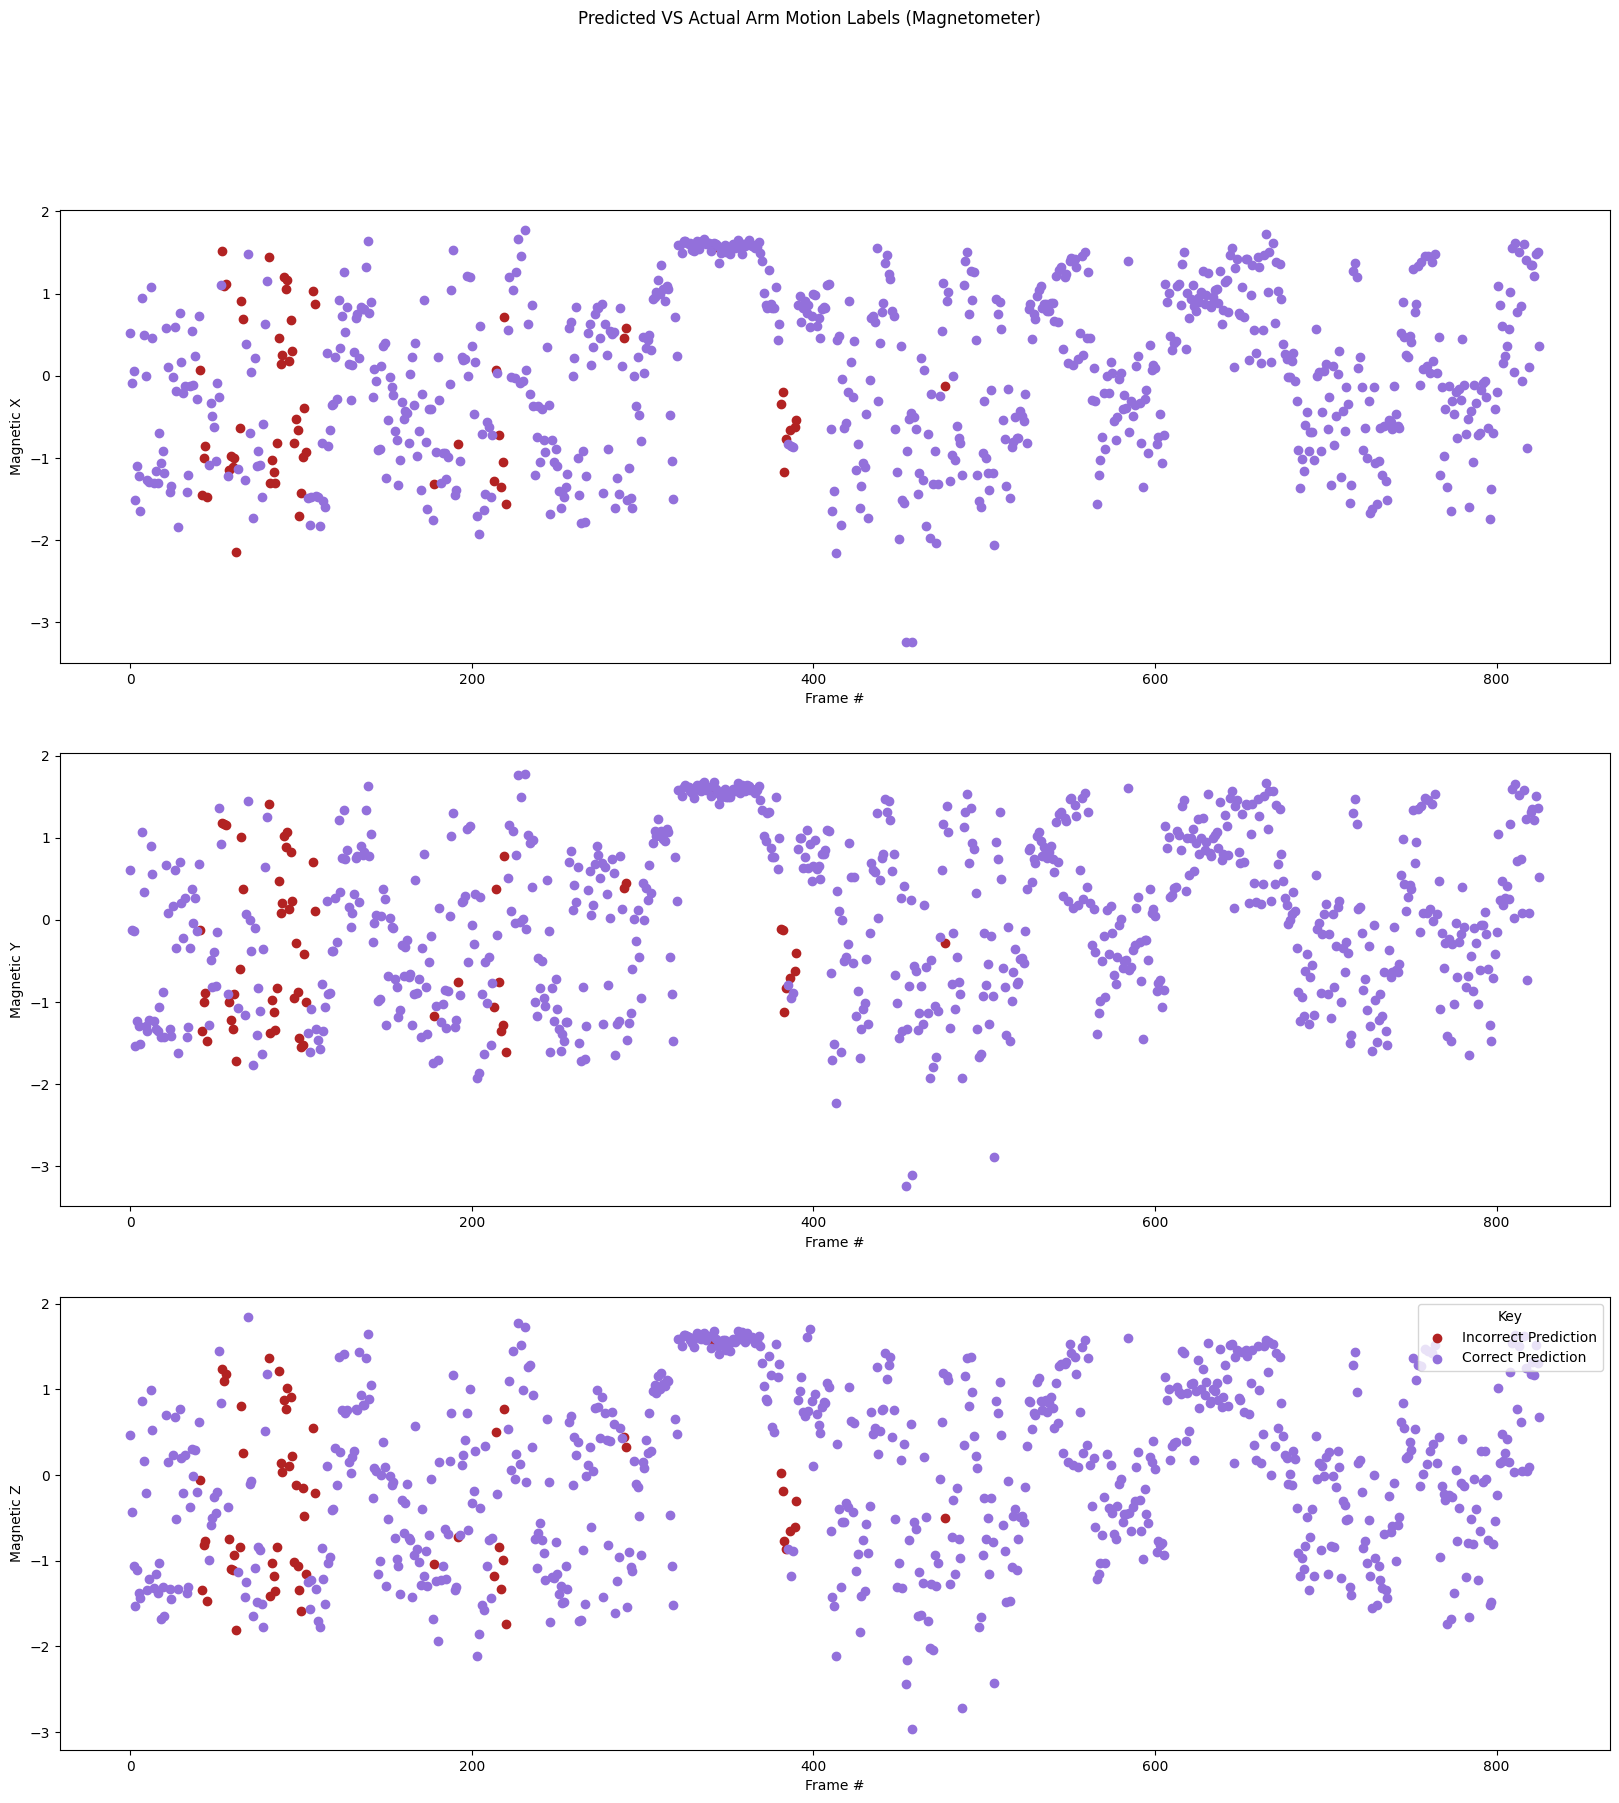

In [22]:
#Magnetic Plot
Label_Accurracy = {0 :'firebrick', 1 :'mediumpurple'}
fig, axs = plt.subplots(3,figsize=(20, 20))
fig.suptitle('Predicted VS Actual Arm Motion Labels (Magnetometer)')

for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[0].scatter(group['Increment'], group['Magnetic X'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[1].scatter(group['Increment'], group['Magnetic Y'], label=key, c=Label_Accurracy[key])
for key, group in A_G_M_arm.groupby('Label Accuracy'):
    axs[2].scatter(group['Increment'], group['Magnetic Z'], label=key, c=Label_Accurracy[key])

# Customize the plot
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Magnetic X')
axs[1].set_xlabel('Frame #')
axs[1].set_ylabel('Magnetic Y')
axs[2].set_xlabel('Frame #')
axs[2].set_ylabel('Magnetic Z')
plt.legend(title='Key', loc = "upper right", labels= ["Incorrect Prediction", "Correct Prediction"])

# Show the plot
plt.show()